In [2]:
import numpy as np
import pandas as pd
import s3fs
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Concatenate
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from typing import List, Set, Dict, Tuple, Optional, Iterable, Callable
import pyarrow
import boto3
import pyarrow.parquet as pq
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report, average_precision_score, 
                             precision_recall_curve, auc, roc_auc_score, plot_precision_recall_curve, plot_roc_curve)
from matplotlib import pyplot as plt

In [3]:
pd.options.display.float_format = '{:20,.3f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.max_colwidth', 0)
s3 = s3fs.S3FileSystem()

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # wide notebook display

In [5]:
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [6]:
physical_device = tensorflow.config.experimental.list_physical_devices('GPU')
print(f'Device found : {physical_device}')

Device found : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))
tensorflow.test.is_gpu_available()
!python3 --version

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8536259489000559359
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14461698048
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14548948886568954908
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:1b.0, compute capability: 7.5"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 14461698048
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18109848068157018409
physical_device_desc: "device: 1, name: Tesla T4, pci bus id: 0000:00:1c.0, compute capability: 7.5"
xla_global_id: 2144165316
, name: "/device:GPU:2"
device_type: "GPU"
memory_limit: 14461698048
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3641552216208988305
physical_device_desc: "device: 2, name: Tesla T4, pci bus id: 0000:00:1d.0, compute capability: 7.5"
xla_global_id: 1651660799
, name: "/device:GPU:3"
device_type: "GPU"
memory_limit: 14461698

In [8]:
feature_path = 's3://aap-aiexpzone-pii-mktg-datascientist-results-prod/ScottSmith/may_2021_page_action_no_checkout_leakage.parquet'

In [9]:
feature_table = pq.ParquetDataset(feature_path, filesystem=s3).read_pandas().to_pandas()

In [10]:
len(feature_table)

5870027

In [11]:
feature_table.columns

Index(['udo_tealium_session_id', 'TYPE_SENTENCE', 'NAME_SENTENCE',
       'CATEGORY_SENTENCE', 'ACTION_SENTENCE', 'LABEL_SENTENCE',
       'DWELL_SENTENCE', 'LABEL'],
      dtype='object')

In [12]:
feature_table.dtypes

udo_tealium_session_id    object
TYPE_SENTENCE             object
NAME_SENTENCE             object
CATEGORY_SENTENCE         object
ACTION_SENTENCE           object
LABEL_SENTENCE            object
DWELL_SENTENCE            object
LABEL                     int32 
dtype: object

In [12]:
len(feature_table.iloc[0, 1].split())

14

### Now we evaluate the class balance

In [13]:
summary = feature_table.groupby('LABEL')['udo_tealium_session_id'].count().reset_index()

In [14]:
summary['FRACTION'] = summary['udo_tealium_session_id']/summary['udo_tealium_session_id'].sum()

In [15]:
summary

LABEL  udo_tealium_session_id             FRACTION
0  0      5542030                               0.944
1  1      327997                                0.056

### Let's look at sequence sizes

In [16]:
feature_table['LENGTH'] = feature_table['TYPE_SENTENCE'].str.split().apply(len)

In [17]:
true_zeros = feature_table[feature_table.LABEL == 0]

In [18]:
true_ones = feature_table[feature_table.LABEL == 1]

In [19]:
true_zeros['LENGTH'].mean()

4.86543432641108

In [20]:
true_ones['LENGTH'].mean()

7.628426479510483

In [21]:
true_ones['NAME_SENTENCE'].head(100)

26      EvaporativeEmissionsVacuumSolenoidValve, VacuumsolenoidResults, VacuumsolenoidResults, VacuumsolenoidvacuumResults, VacuumResults, ATF4FullSyntheticAutomaticTransmissionFluid1Quart, AddedToCartPage, transmissionfluidResults                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [22]:
true_zeros['ACTION_SENTENCE'].head(100)

0      ASSYLUBE, Page, Page, ASSYLUBEGREASE, Page, Page, Page, ENGINEASSYLUBEGREASE, Page, Page, LUBERPLATEGREASE, Page, Page, l0034094                                                                                                                                                                                                                                                               
1      addtocart                                                                                                                                                                                                                                                                                                                                                                                      
2      Garage, Garage, Garage, Garage, Garage, Garage, Garage                                                                                                                                                             

#### We want the mean sequence lengths of true positives and negatives to be as close as possible to each other to avoid the model over relying on sequence length.

In [23]:
(true_zeros['LENGTH']==1).sum()/len(true_zeros)

0.1793573834858346

In [24]:
(true_ones['LENGTH']==1).sum()/len(true_ones)

0.09087583118138276

In [25]:
(true_zeros['LENGTH']==2).sum()/len(true_zeros)

0.17035923659742008

In [26]:
(true_ones['LENGTH']==2).sum()/len(true_ones)

0.10037896688079465

In [27]:
(true_zeros['LENGTH']==3).sum()/len(true_zeros)

0.1503950718419063

In [28]:
(true_ones['LENGTH']==3).sum()/len(true_ones)

0.08491541081168426

#### Although the true negatives are shorter, the differcence should not impact the model very much

### Now we filter our data so that the minimum sequence length is seven.  This will prevent the model from learning that longer sequences have a higher probablity of conversion

In [29]:
feature_table_reduced = feature_table[feature_table.LENGTH >=7]

In [30]:
len(feature_table_reduced)

1410894

### First we do a train/test stratified split. We must do this prior to creating dictionaries.  In fact, we need to go back to the spark notebook and fix the defintion of dwell buckets rather than determine them using all data

In [13]:
def process_sentences(sentence_series: pd.Series,
                      maxlen: int, 
                      padding: str = 'pre', 
                      truncating: str ='post',
                      tokenizer: Tokenizer = None,
                      num_words: int = None,) -> np.array:
    """Function to use a fit tokenizer to convert a pandas series of sentences into a numpy array
    of integers.  This numpy array will have the same number of rows as elements of the sentence
    series and maxlen number of columns. This matrix will represent each word in the sequence by an 
    integer, with 1 standing for the UNKNOWN token, 0 for padding, and numbers representing the 
    vocabulary size defined by fit_tokenizer.
    
    Parameters
    ----------
     sentence_series: pd.Series
        A series of text elements, each containing a sentence of words separated by spaces
         
     maxlen: int
         The maximum number of words in a sentence to be kept
         
     padding: str
         If 'pre', the sentences are left padded with 0 values if less than maxlen
         if 'post' the sentences are right padded with 0 values if less than maxlen
         
     truncating: str
         If 'pre', the sentences are truncated from the left if greater than maxlen.
         This keeps the earliest sequence values
         if 'post' the sentences are truncated from the right if greater than maxlen.
         This keeps the latest sequence values
         
     tokenizer: Tokenizer
         A fit Tokenizer object. If none, a new tokenizer will be fit on the data
         
     num_words: int
         The number of words to be in the vocabulary for this sequence.  This must
         be specified if fit_tokenizer is None.
    
    Returns
    -------
    A numpy array of containing a row for each sequence and a column for each token. The
    second dimension is always maxlen.
    """
    # Convert the series of sentences to a list
    sentence_list = sentence_series.tolist()
    
    # Fit the fit tokenizer if necessary
    if tokenizer is None:
        tokenizer = Tokenizer(
            num_words=num_words,
            filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
            lower=True, 
            split=', ', 
            char_level=False, 
            oov_token="UNKNOWN")
        tokenizer.fit_on_texts(sentence_list)
    
    # Create the sequences of indicies
    sequences = tokenizer.texts_to_sequences(sentence_list)
    
    # Truncate and pad the sequences
    output = pad_sequences(sequences, maxlen=maxlen, padding=padding, truncating=truncating)
    
    return output, tokenizer   

### Let's only use 10% of the data

In [32]:
feature_table_subset = feature_table.groupby('LABEL').sample(frac=0.1, random_state=3)

In [33]:
len(feature_table), len(feature_table_subset)

(5870027, 587003)

### Now split the data into train and test

In [34]:
X_train, X_test, y_train, y_test = train_test_split(feature_table_subset[['TYPE_SENTENCE', 'NAME_SENTENCE', 'CATEGORY_SENTENCE', 'ACTION_SENTENCE', 'LABEL_SENTENCE', 'DWELL_SENTENCE']], 
                                                    feature_table_subset['LABEL'], 
                                                    test_size=0.10, random_state=1, stratify=feature_table_subset['LABEL'])

In [35]:
X_train.head(10)

TYPE_SENTENCE  \
3701305  home, home, L3, L3, L3, PRODUCT, L3, PRODUCT, PRODUCT                                                  
3894930  home, L3, PRODUCT, PRODUCT, home, search, search, search, search, search                               
1461044  home, home, search, search, search, reactsearch, search, search, search, search, reactsearch, search   
4062195  home, home, home, L3, search, search, search, generic, search                                          
5057579  PRODUCT, search, search                                                                                
1513001  L3, search, search                                                                                     
1634906  L3, L3                                                                                                 
5831481  home, home, search                                                                                     
2002826  PRODUCT                                                                                                
2576353  L3                                                                                                     

                                                                                                                                                                                                                                                                                                                                        NAME_SENTENCE  \
3701305  Homepage, Homepage, RadiatorsResults, RadiatorsResults, RadiatorsResults, OEQualityRadiator, RadiatorsResults, Radiator, Radiator                                                                                                                                                                                                              
3894930  Homepage, BrakePadsampShoesResults, BrakeShoesNewRear, BrakeShoesNewRear, Homepage, WagnerZ705RDrumBrakeShoeSetResults, DrumBrakeShoeSetResults, DrumBrakeShoeSetResults, DrumBrakeShoeSetrearResults, DrumBrakeShoeSetrearResults                                                                                                             
1461044  Homepage, Homepage, 2011infinitig25accompressorResults, 2011infinitig25accompressorResults, 2011infinitig25accompressorResults, reactsearch, 2011infinitig25accompressorResults, 2011infinitig25accompressorResults, 2011infinitig25accompressorResults, 2011infinitig25accompressorResults, reactsearch, 2011infinitig25accompressorResults   
4062195  Homepage, Homepage, Homepage, EngineComponentsResults, timingchainResults, timingchaintensionerResults, timingchaintensionerResults, generic, timingchainResults                                                                                                                                                                               
5057579  OriginalEquipmentAirFilter, Motorcraftfa1912aResults, Motorcraft5w30oilResults                                                                                                                                                                                                                                                                 
1513001  BrakePadsampShoesResults, frontbrakecaliperResults, frontbrakecaliperResults                                                                                                                                                                                                                                                                   
1634906  FuelInjectorsResults, FuelInjectorsResults                                                                                                                                                                                                                                                                                                     
5831481  Homepage, Homepage, motormountResults                                              

### Split data into list of labels and 5 lists of features

In [36]:
X_train_type = X_train['TYPE_SENTENCE'].tolist()
X_test_type = X_test['TYPE_SENTENCE'].tolist()
X_train_name = X_train['NAME_SENTENCE'].tolist()
X_test_name = X_test['NAME_SENTENCE'].tolist()
X_train_category = X_train['CATEGORY_SENTENCE'].tolist()
X_test_category = X_test['CATEGORY_SENTENCE'].tolist()
X_train_action = X_train['ACTION_SENTENCE'].tolist()
X_test_action = X_test['ACTION_SENTENCE'].tolist()
X_train_label = X_train['LABEL_SENTENCE'].tolist()
X_test_label = X_test['LABEL_SENTENCE'].tolist()
X_train_dwell = X_train['DWELL_SENTENCE'].tolist()
X_test_dwell = X_test['DWELL_SENTENCE'].tolist()

In [37]:
X_train_type[0]

'home, home, L3, L3, L3, PRODUCT, L3, PRODUCT, PRODUCT'

In [38]:
X_train_name[0]

'Homepage, Homepage, RadiatorsResults, RadiatorsResults, RadiatorsResults, OEQualityRadiator, RadiatorsResults, Radiator, Radiator'

In [39]:
X_train_label[0]

'2005ToyotaRAV424L2362CCL4FIVIN2AZFE, RedirectUnbxd, PriceHighLow, AZSortOff, 10802426, 10802426P, 19920512, 2005ToyotaRAV424L2362CCL4FIVIN2AZFE, 19920512P'

In [40]:
X_train_dwell[0]

'10, 40, 10, 30, 20, 50, 20, 40, 10'

In [41]:
y_train.head()

3701305    0
3894930    0
1461044    0
4062195    0
5057579    0
Name: LABEL, dtype: int32

In [42]:
tokenizer = Tokenizer(
    num_words=400,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, 
    split=', ', 
    char_level=False, 
    oov_token="UNKNOWN")

### Prepare sequences for modeling.  Note that we pass the fit tokenizer when we prepare the test sequences

#### We create an empty dictionary.  The keys will be the sentence name, the values will be the train and test indicies

In [43]:
data_dict = {}

In [44]:
vocab_size_dict = {'TYPE_SENTENCE': 50,
                   'NAME_SENTENCE': 40000,
                   'CATEGORY_SENTENCE': 1900,
                   'ACTION_SENTENCE': 20000,
                   'LABEL_SENTENCE': 40000,
                   'DWELL_SENTENCE': 11
                  }

In [45]:
for column_name, size in vocab_size_dict.items():
    print(f'Starting {column_name} with size {size}')
    data_dict[column_name] = {}
    data_dict[column_name]['train'], fit_tokenizer = process_sentences(sentence_series=X_train[column_name], maxlen=7, num_words=size)
    data_dict[column_name]['test'], _ = process_sentences(sentence_series=X_test[column_name], maxlen=7, tokenizer=fit_tokenizer)
    

Starting TYPE_SENTENCE with size 50
Starting NAME_SENTENCE with size 40000
Starting CATEGORY_SENTENCE with size 1900
Starting ACTION_SENTENCE with size 20000
Starting LABEL_SENTENCE with size 40000
Starting DWELL_SENTENCE with size 11


In [46]:
data_dict['DWELL_SENTENCE']['train'][:10]

array([[ 1,  2,  3, 10,  9,  8,  9],
       [ 1,  5,  4,  7,  2,  2,  5],
       [ 1,  5,  6,  5,  2,  5,  6],
       [ 1,  8,  7,  8,  4,  3,  2],
       [ 0,  0,  0,  0,  1,  8,  2],
       [ 0,  0,  0,  0,  1,  8,  8],
       [ 0,  0,  0,  0,  0,  1,  4],
       [ 0,  0,  0,  0,  1,  6,  9],
       [ 0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  1]], dtype=int32)

In [47]:
data_dict['TYPE_SENTENCE']['train'][:10]

array([[ 5,  4,  6,  6,  6,  3,  6],
       [ 5,  6,  3,  3,  4,  2,  2],
       [ 5,  4,  2,  2,  2,  8,  2],
       [ 5,  4,  4,  6,  2,  2,  2],
       [ 0,  0,  0,  0,  7,  2,  2],
       [ 0,  0,  0,  0, 10,  2,  2],
       [ 0,  0,  0,  0,  0, 10,  6],
       [ 0,  0,  0,  0,  5,  4,  2],
       [ 0,  0,  0,  0,  0,  0,  7],
       [ 0,  0,  0,  0,  0,  0, 10]], dtype=int32)

In [48]:
data_dict['ACTION_SENTENCE']['train'][:10]

array([[  681,   128,    79,     8,    13,    12,    13],
       [   18,    13,    17,  6040,     1,     1,     3],
       [    1,    10,     3,    10,     6,    10,    10],
       [    4,     2,   348,   326,  1303,  7203,  7203],
       [    0,     0,     0,     0,     1, 18487,     6],
       [    0,     0,     0,     0,   284,    11,     5],
       [    0,     0,     0,     0,     0,    15,   918],
       [    0,     0,     0,     0,    50,   142,     3],
       [    0,     0,     0,     0,     0,     0,    25],
       [    0,     0,     0,     0,     0,     0,    31]], dtype=int32)

In [49]:
data_dict['LABEL_SENTENCE']['train'][:10]

array([[ 9848,    18,   263,    13,     1,     1,     1],
       [   59,     1,     1,   620,   620,   620,     2],
       [    6,    23,     2,    23,     1,    23,    92],
       [   11,     9,  7952,  7952,  7952,  7952,  7952],
       [    0,     0,     0,     0,     6,     3,     1],
       [    0,     0,     0,     0, 32823,     4,     4],
       [    0,     0,     0,     0,     0,    17,  1021],
       [    0,     0,     0,     0,    31,  2691,     2],
       [    0,     0,     0,     0,     0,     0,   100],
       [    0,     0,     0,     0,     0,     0,    20]], dtype=int32)

In [50]:
data_dict['NAME_SENTENCE']['train'][:10]

array([[    3,     2,    30,    30,    30,  6307,    30],
       [    3,    10,   334,   334,     2,     1,     1],
       [    3,     2, 16901, 16901, 16901,     4, 16901],
       [    3,     2,     2,   792,   687,  2745,  2745],
       [    0,     0,     0,     0,  1948,     1,     1],
       [    0,     0,     0,     0,    28,    93,    93],
       [    0,     0,     0,     0,     0,  1358,   172],
       [    0,     0,     0,     0,     3,     2,   186],
       [    0,     0,     0,     0,     0,     0,     1],
       [    0,     0,     0,     0,     0,     0,  5432]], dtype=int32)

In [51]:
data_dict['CATEGORY_SENTENCE']['train'][:10]

array([[ 7, 19, 10, 10,  2,  5,  2],
       [17,  2, 11,  4,  4,  4,  2],
       [ 7,  2,  2,  2,  2,  2,  2],
       [ 6,  3, 12,  4,  4,  4, 14],
       [ 0,  0,  0,  0,  7,  4,  2],
       [ 0,  0,  0,  0, 15,  2,  2],
       [ 0,  0,  0,  0,  0, 16,  4],
       [ 0,  0,  0,  0,  6,  8,  2],
       [ 0,  0,  0,  0,  0,  0,  9],
       [ 0,  0,  0,  0,  0,  0, 18]], dtype=int32)

### Our data is now fully prepared.  We now begin our modeling in keras

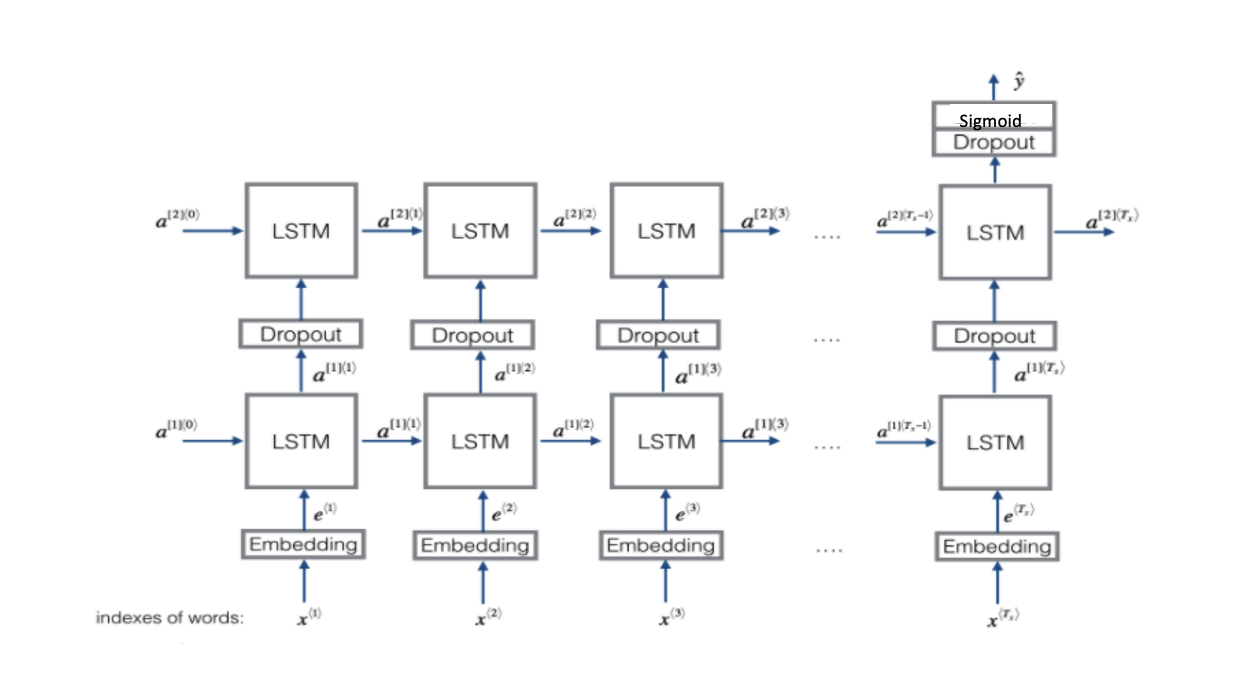

#### Above is our architecure.  We will add all layers in the architecure, but to start we will set dropout to 0.0 to start and try to minimze the training error

#### Let's set up our system so that we use all GPUs

In [52]:
strategy = tensorflow.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [53]:
def ClickStreamPageModel(input_shape):
    """
    Function creating the click stream model using page names per the graph above
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the model
    name_sentence_indices = Input(shape=input_shape, dtype='int32')
    action_sentence_indicies = Input(shape=input_shape, dtype='int32')
    label_sentence_indicies = Input(shape=input_shape, dtype='int32')
    dwell_sentence_indicies = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layers and propogate the input through these, then append these to create a 57 dimension input
    name_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(name_sentence_indices)
    action_emb = Embedding(input_dim=20001, output_dim=25, trainable=True, mask_zero=True)(action_sentence_indicies)
    label_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(label_sentence_indicies)
    dwell_emb = Embedding(input_dim=12, output_dim=2, trainable=True, mask_zero=True)(dwell_sentence_indicies)
    X = Concatenate()([name_emb, action_emb, label_emb, dwell_emb])
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units=128, return_sequences=True)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X)
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units=128, return_sequences=False)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X) 
    
    # Propagate X through a Dense layer with 1 unit
    X = Dense(units=1)(X)
    # Add a sigmod activation
    X = Activation('sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[name_sentence_indices, action_sentence_indicies, label_sentence_indicies, dwell_sentence_indicies], outputs=X)
    
    return model

In [54]:
#with strategy.scope():
model = ClickStreamPageModel(7)

In [55]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 7)]          0           []                               
                                                                                              

In [56]:
#with strategy.scope():
aupr = tensorflow.keras.metrics.AUC(
    num_thresholds=50,
    curve="PR",
    summation_method="interpolation",
    name='aupr',
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False,
)

### We define callbacks for early stopping and saving the best model

In [57]:
#with strategy.scope():
early_stopping_callback = tensorflow.keras.callbacks.EarlyStopping(
    monitor="val_aupr",
    min_delta=0,
    patience=4,
    verbose=0,
    mode="max",
    baseline=None,
    restore_best_weights=True,
)

In [58]:
#with strategy.scope():
model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-5), metrics=[aupr, 'accuracy'])

In [59]:
#with strategy.scope():
model.fit([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']],
           y_train,
           callbacks=[early_stopping_callback],
           epochs = 1, 
           batch_size = 32, 
           shuffle=True, 
           validation_split=0.5)

8255/8255 [==============================] - 285s 34ms/step - loss: 0.3482 - aupr: 0.0538 - accuracy: 0.9430 - val_loss: 0.2010 - val_aupr: 0.1469 - val_accuracy: 0.9435


In [60]:
#with strategy.scope():
model.fit([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']],
           y_train,
           callbacks=[early_stopping_callback],
           epochs = 30, 
           batch_size = 32, 
           shuffle=True, 
           validation_split=0.5)

Epoch 1/30
8255/8255 [==============================] - 275s 33ms/step - loss: 0.1743 - aupr: 0.2386 - accuracy: 0.9425 - val_loss: 0.1609 - val_aupr: 0.2884 - val_accuracy: 0.9415
Epoch 2/30
8255/8255 [==============================] - 275s 33ms/step - loss: 0.1549 - aupr: 0.3125 - accuracy: 0.9419 - val_loss: 0.1529 - val_aupr: 0.3154 - val_accuracy: 0.9417
Epoch 3/30
8255/8255 [==============================] - 274s 33ms/step - loss: 0.1480 - aupr: 0.3352 - accuracy: 0.9421 - val_loss: 0.1492 - val_aupr: 0.3279 - val_accuracy: 0.9422
Epoch 4/30
8255/8255 [==============================] - 275s 33ms/step - loss: 0.1445 - aupr: 0.3462 - accuracy: 0.9425 - val_loss: 0.1467 - val_aupr: 0.3344 - val_accuracy: 0.9423
Epoch 5/30
8255/8255 [==============================] - 276s 33ms/step - loss: 0.1416 - aupr: 0.3567 - accuracy: 0.9429 - val_loss: 0.1456 - val_aupr: 0.3386 - val_accuracy: 0.9425
Epoch 6/30
8255/8255 [==============================] - 275s 33ms/step - loss: 0.1396 - aupr: 0

In [61]:
training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']
training_aupr = model.history.history['aupr']
validation_aupr = model.history.history['val_aupr']

#### Remove the first item from the training list and the last item from the validation list.  This is due to the fact that reported training metrics are the mean of all the metrics in the epoch, but validation metrics are taken at the end of the epoch

In [62]:
validation_loss = validation_loss[:-1]

In [63]:
training_loss = training_loss[1:]

In [64]:
validation_aupr = validation_aupr[:-1]

In [65]:
training_aupr = training_aupr[1:]

In [66]:
len(validation_loss), len(training_loss), len(validation_aupr), len(training_aupr)

(13, 13, 13, 13)

In [67]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

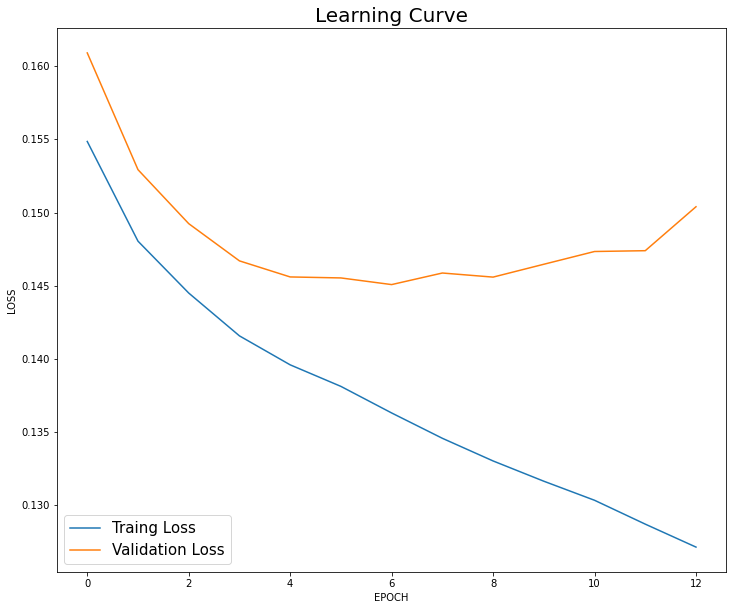

In [68]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss, label='Traing Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

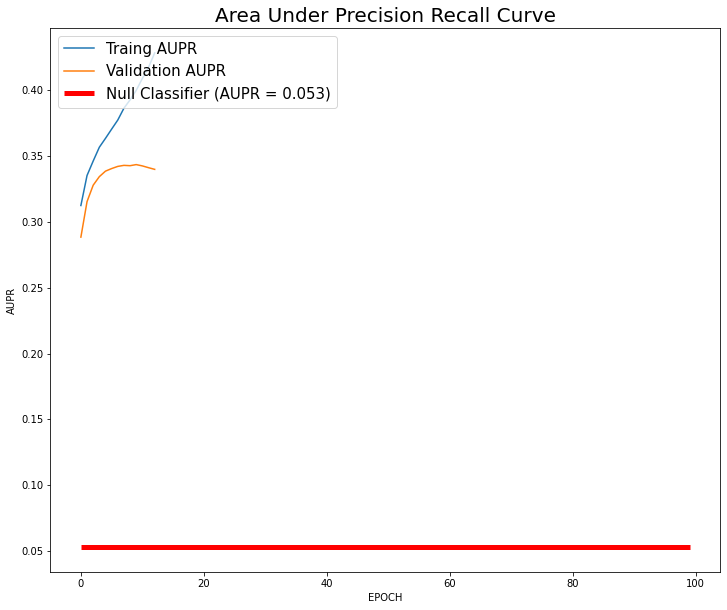

In [69]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr, label='Traing AUPR')
plt.plot(validation_aupr, label='Validation AUPR')
plt.hlines(0.053, 0.0, 99.0, colors='red', label="Null Classifier (AUPR = 0.053)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

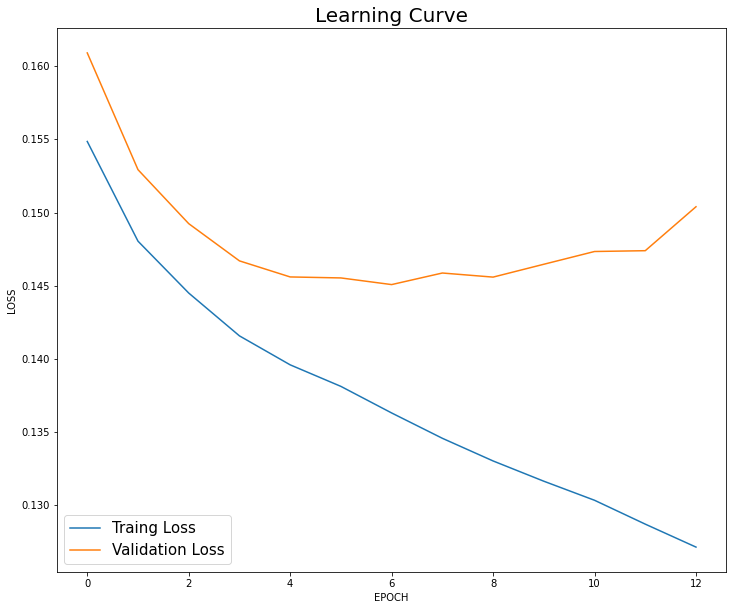

In [70]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss[:25], label='Traing Loss')
plt.plot(validation_loss[0:25], label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

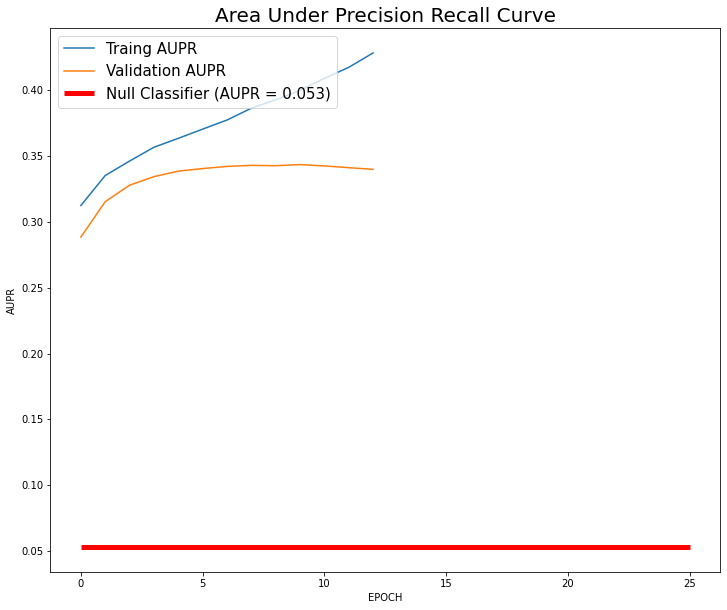

In [71]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr[:25], label='Traing AUPR')
plt.plot(validation_aupr[:25], label='Validation AUPR')
plt.hlines(0.053, 0.0, 25.0, colors='red', label="Null Classifier (AUPR = 0.053)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

In [72]:
def print_conversion_metrics(y_true, y_pred_classes, y_pred_probs, title):
    cmtx = pd.DataFrame(
    confusion_matrix(y_true=y_true, y_pred=y_pred_classes), 
                     index=['true: not converted', 'true: converted'], columns=['pred: not converted', 'pred: converted'])
    print(title)
    print(cmtx)
    print('\n')
    print(classification_report(y_true, y_pred_classes))
    print(f'The area under the PR curve is approximately {average_precision_score(y_true, y_pred_probs, pos_label=1):1.2f}')
    

In [73]:
predictions_train = model.predict([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']])
predicted_classes_train = np.where(predictions_train > 0.5, 1, 0)

In [74]:
print_conversion_metrics(y_train, predicted_classes_train, predictions_train, 'Training Results')

Training Results
                     pred: not converted  pred: converted
true: not converted  494900               3882           
true: converted      25925                3595           


              precision    recall  f1-score   support

           0       0.95      0.99      0.97    498782
           1       0.48      0.12      0.19     29520

    accuracy                           0.94    528302
   macro avg       0.72      0.56      0.58    528302
weighted avg       0.92      0.94      0.93    528302

The area under the PR curve is approximately 0.38


#### Confusion matrix for training  is as expected

#### Now we create the confustion matrix for test

In [75]:
predictions_test = model.predict([data_dict['NAME_SENTENCE']['test'], 
           data_dict['ACTION_SENTENCE']['test'],
           data_dict['LABEL_SENTENCE']['test'],
           data_dict['DWELL_SENTENCE']['test']])


In [76]:
predicted_classes_test = np.where(predictions_test > 0.19, 1, 0)

In [77]:
print_conversion_metrics(y_test, predicted_classes_test, predictions_test, 'Test Results')

Test Results
                     pred: not converted  pred: converted
true: not converted  51028                4393           
true: converted      1112                 2168           


              precision    recall  f1-score   support

           0       0.98      0.92      0.95     55421
           1       0.33      0.66      0.44      3280

    accuracy                           0.91     58701
   macro avg       0.65      0.79      0.69     58701
weighted avg       0.94      0.91      0.92     58701

The area under the PR curve is approximately 0.35


# Now we  double our data size and add an early stopping callback

### Let's only  20% of the data

In [78]:
feature_table_subset = feature_table.groupby('LABEL').sample(frac=0.2, random_state=3)

In [79]:
len(feature_table), len(feature_table_subset)

(5870027, 1174005)

### Now split the data into train and test

In [80]:
X_train, X_test, y_train, y_test = train_test_split(feature_table_subset[['TYPE_SENTENCE', 'NAME_SENTENCE', 'CATEGORY_SENTENCE', 'ACTION_SENTENCE', 'LABEL_SENTENCE', 'DWELL_SENTENCE']], 
                                                    feature_table_subset['LABEL'], 
                                                    test_size=0.10, random_state=1, stratify=feature_table_subset['LABEL'])

In [81]:
X_train.head(10)

TYPE_SENTENCE  \
1837613  home, home, home                                                                                    
5403739  home, home, search, reactsearch, search, reactsearch, search                                        
2065917  L3, L3, L3, L3                                                                                      
3507986  generic                                                                                             
945990   home, search                                                                                        
4019766  PRODUCT, PRODUCT, PRODUCT, PRODUCT                                                                  
5047103  home, search, search, search, search, search                                                        
3494560  home, home, home, home, search, store, search                                                       
3567818  home, home, home, search, search, reactsearch, search, PRODUCT, generic, generic, search, PRODUCT   
2989932  PRODUCT                                                                                             

                                                                                                                                                                                                               NAME_SENTENCE  \
1837613  Homepage, Homepage, Homepage                                                                                                                                                                                          
5403739  Homepage, Homepage, floormatsResults, reactsearch, floormatsResults, reactsearch, floormatsResults                                                                                                                    
2065917  CarBatteriesResults, CarBatteriesResults, CarBatteriesResults, CarBatteriesResults                                                                                                                                    
3507986  generic                                                                                                                                                                                                               
945990   Homepage, S14377Results                                                                                                                                                                                               
4019766  PerformanceIntakeKit, PerformanceIntakeKit, PerformanceIntakeKit, ColdAirIntakeKitwithMillionMileAirFilterAddsupto7Horsepower                                                                                         
5047103  Homepage, BlackwrinklepaintResults, BlackpaintResults, spraypaintResults, GunmetalpaintResults, GunmetalpaintResults                                                                                                  
3494560  Homepage, Homepage, Homepage, Homepage, frontwheelbearingandhubResults, StoreDetails, HubResults                                                                                                                      
3567818  Homepage, Homepage, Homepage, steeringstabilizerResults, steeringstabilizerResults, reactsearch, steeringstabilizerResults, MagnumSteeringDamper, generic, generic, steeringstabilizerResults, MagnumSteeringDamper   
2989932  CertifiedR1234yfGaugeHoseSet                                                                                                                                                                                          

                                                                                                                                                                          CATEGORY_SENTENCE  \
1837613  Header, Header, UnbxdSearchAutoSuggest                                                                                                                                               
5403739  Header, UnbxdSearch, Produ

### Split data into list of labels and 5 lists of features

In [82]:
X_train_type = X_train['TYPE_SENTENCE'].tolist()
X_test_type = X_test['TYPE_SENTENCE'].tolist()
X_train_name = X_train['NAME_SENTENCE'].tolist()
X_test_name = X_test['NAME_SENTENCE'].tolist()
X_train_category = X_train['CATEGORY_SENTENCE'].tolist()
X_test_category = X_test['CATEGORY_SENTENCE'].tolist()
X_train_action = X_train['ACTION_SENTENCE'].tolist()
X_test_action = X_test['ACTION_SENTENCE'].tolist()
X_train_label = X_train['LABEL_SENTENCE'].tolist()
X_test_label = X_test['LABEL_SENTENCE'].tolist()
X_train_dwell = X_train['DWELL_SENTENCE'].tolist()
X_test_dwell = X_test['DWELL_SENTENCE'].tolist()

In [83]:
X_train_type[0]

'home, home, home'

In [84]:
X_train_name[0]

'Homepage, Homepage, Homepage'

In [85]:
X_train_label[0]

'AddaVehicleStart, AddaVehicleComplete, 2003DodgeRam2500SLT59L359CIL6DieselTurboVINC'

In [86]:
X_train_dwell[0]

'50, 60, 70'

In [87]:
y_train.head()

1837613    0
5403739    0
2065917    0
3507986    0
945990     1
Name: LABEL, dtype: int32

In [88]:
tokenizer = Tokenizer(
    num_words=400,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, 
    split=', ', 
    char_level=False, 
    oov_token="UNKNOWN")

### Prepare sequences for modeling.  Note that we pass the fit tokenizer when we prepare the test sequences

#### We create an empty dictionary.  The keys will be the sentence name, the values will be the train and test indicies

In [89]:
data_dict = {}

In [90]:
vocab_size_dict = {'TYPE_SENTENCE': 50,
                   'NAME_SENTENCE': 40000,
                   'CATEGORY_SENTENCE': 1900,
                   'ACTION_SENTENCE': 20000,
                   'LABEL_SENTENCE': 40000,
                   'DWELL_SENTENCE': 11
                  }

In [91]:
for column_name, size in vocab_size_dict.items():
    print(f'Starting {column_name} with size {size}')
    data_dict[column_name] = {}
    data_dict[column_name]['train'], fit_tokenizer = process_sentences(sentence_series=X_train[column_name], maxlen=7, num_words=size)
    data_dict[column_name]['test'], _ = process_sentences(sentence_series=X_test[column_name], maxlen=7, tokenizer=fit_tokenizer)
    

Starting TYPE_SENTENCE with size 50
Starting NAME_SENTENCE with size 40000
Starting CATEGORY_SENTENCE with size 1900
Starting ACTION_SENTENCE with size 20000
Starting LABEL_SENTENCE with size 40000
Starting DWELL_SENTENCE with size 11


In [92]:
data_dict['DWELL_SENTENCE']['train'][:10]

array([[0, 0, 0, 0, 1, 6, 5],
       [1, 2, 2, 2, 2, 9, 3],
       [0, 0, 0, 1, 9, 5, 9],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 6],
       [0, 0, 0, 1, 2, 5, 6],
       [0, 1, 6, 4, 2, 5, 5],
       [1, 5, 2, 8, 5, 9, 8],
       [1, 5, 4, 8, 8, 9, 4],
       [0, 0, 0, 0, 0, 0, 1]], dtype=int32)

In [93]:
data_dict['TYPE_SENTENCE']['train'][:10]

array([[ 0,  0,  0,  0,  5,  4,  4],
       [ 5,  4,  2,  8,  2,  8,  2],
       [ 0,  0,  0, 10,  6,  6,  6],
       [ 0,  0,  0,  0,  0,  0, 16],
       [ 0,  0,  0,  0,  0,  5,  2],
       [ 0,  0,  0,  7,  3,  3,  3],
       [ 0,  5,  2,  2,  2,  2,  2],
       [ 5,  4,  4,  4,  2,  9,  2],
       [ 5,  4,  4,  2,  2,  8,  2],
       [ 0,  0,  0,  0,  0,  0,  7]], dtype=int32)

In [94]:
data_dict['ACTION_SENTENCE']['train'][:10]

array([[   0,    0,    0,    0,    4,    2,  135],
       [   4,  192,    6,  192,    6,  192,    3],
       [   0,    0,    0,   28,    2,    2,    2],
       [   0,    0,    0,    0,    0,    0,   50],
       [   0,    0,    0,    0,    0,    1,    5],
       [   0,    0,    0,    4,    2,    2,    5],
       [   0,    1, 3315,  645,    1,    3,    3],
       [   4,    2,    2,   64,   14,  721,   64],
       [   4,    2,  624,    3,    6,  624,    6],
       [   0,    0,    0,    0,    0,    0,   19]], dtype=int32)

In [95]:
data_dict['LABEL_SENTENCE']['train'][:10]

array([[    0,     0,     0,     0,    11,     9,  5860],
       [   45,  2909, 10011,  2909, 20540,  2909,     2],
       [    0,     0,     0,    38,    12,     5,     7],
       [    0,     0,     0,     0,     0,     0,   289],
       [    0,     0,     0,     0,     0,     6,     4],
       [    0,     0,     0,    10,     5,     7,     4],
       [    0,     1, 21720, 21720, 21720,     2,     8],
       [   10,     5,     7, 20541,    16, 20541, 20541],
       [   36,    22, 21721,     2, 30733, 21721,     1],
       [    0,     0,     0,     0,     0,     0,   115]], dtype=int32)

In [96]:
data_dict['NAME_SENTENCE']['train'][:10]

array([[    0,     0,     0,     0,     3,     2,     2],
       [    3,     2,    97,     4,    97,     4,    97],
       [    0,     0,     0,    20,    11,    11,    11],
       [    0,     0,     0,     0,     0,     0,    14],
       [    0,     0,     0,     0,     0,     3,     1],
       [    0,     0,     0,  3702,  1710,  1710, 10304],
       [    0,     3,     1,  3114,   423,     1,     1],
       [    3,     2,     2,     2,    44,    15,  1139],
       [    3,     2,     2,  1100,  1100,     4,  1100],
       [    0,     0,     0,     0,     0,     0,  1694]], dtype=int32)

In [97]:
data_dict['CATEGORY_SENTENCE']['train'][:10]

array([[ 0,  0,  0,  0,  6,  3,  8],
       [ 6,  4,  2,  4,  2,  4,  2],
       [ 0,  0,  0, 18,  3,  3,  3],
       [ 0,  0,  0,  0,  0,  0,  6],
       [ 0,  0,  0,  0,  0,  7,  2],
       [ 0,  0,  0,  6,  3,  3,  5],
       [ 0,  7,  4,  4,  4,  2,  2],
       [ 6,  3,  3,  8,  3,  4,  4],
       [ 6,  3,  8,  2,  2,  4,  2],
       [ 0,  0,  0,  0,  0,  0,  9]], dtype=int32)

### Our data is now fully prepared.  We now begin our modeling in keras

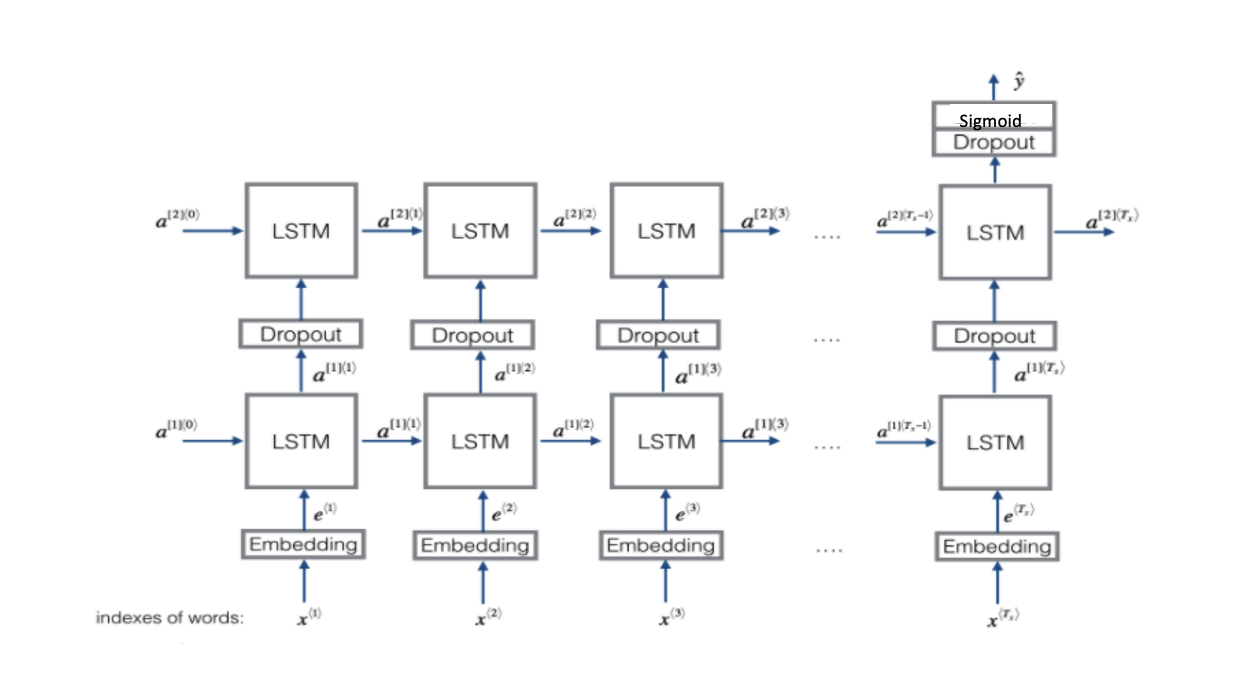

#### Above is our architecure.  We will add all layers in the architecure, but to start we will set dropout to 0.0 to start and try to minimze the training error

In [98]:
def ClickStreamPageModel(input_shape):
    """
    Function creating the click stream model using page names per the graph above
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the model
    name_sentence_indices = Input(shape=input_shape, dtype='int32')
    action_sentence_indicies = Input(shape=input_shape, dtype='int32')
    label_sentence_indicies = Input(shape=input_shape, dtype='int32')
    dwell_sentence_indicies = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layers and propogate the input through these, then append these to create a 57 dimension input
    name_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(name_sentence_indices)
    action_emb = Embedding(input_dim=20001, output_dim=25, trainable=True, mask_zero=True)(action_sentence_indicies)
    label_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(label_sentence_indicies)
    dwell_emb = Embedding(input_dim=12, output_dim=2, trainable=True, mask_zero=True)(dwell_sentence_indicies)
    X = Concatenate()([name_emb, action_emb, label_emb, dwell_emb])
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units=128, return_sequences=True)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X)
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units=128, return_sequences=False)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X) 
    
    # Propagate X through a Dense layer with 1 unit
    X = Dense(units=1)(X)
    # Add a sigmod activation
    X = Activation('sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[name_sentence_indices, action_sentence_indicies, label_sentence_indicies, dwell_sentence_indicies], outputs=X)
    
    return model

In [99]:
model = ClickStreamPageModel(7)

In [100]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 7)]          0           []                               
                                                                                            

In [101]:
aupr = tensorflow.keras.metrics.AUC(
    num_thresholds=50,
    curve="PR",
    summation_method="interpolation",
    name='aupr',
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False,
)

### We define callbacks for early stopping and saving the best model

In [102]:
early_stopping_callback = tensorflow.keras.callbacks.EarlyStopping(
    monitor="val_aupr",
    min_delta=0,
    patience=4,
    verbose=0,
    mode="max",
    baseline=None,
    restore_best_weights=True,
)

In [103]:
model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-5), metrics=[aupr, 'accuracy'])

In [104]:
model.fit([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']],
           y_train, 
           callbacks=[early_stopping_callback],
           epochs = 100, 
           batch_size = 32, 
           shuffle=True, 
           validation_split=0.5)

Epoch 1/100
16510/16510 [==============================] - 560s 34ms/step - loss: 0.2621 - aupr: 0.0905 - accuracy: 0.9428 - val_loss: 0.1616 - val_aupr: 0.2852 - val_accuracy: 0.9421
Epoch 2/100
16510/16510 [==============================] - 551s 33ms/step - loss: 0.1539 - aupr: 0.3135 - accuracy: 0.9421 - val_loss: 0.1490 - val_aupr: 0.3269 - val_accuracy: 0.9422
Epoch 3/100
16510/16510 [==============================] - 551s 33ms/step - loss: 0.1458 - aupr: 0.3397 - accuracy: 0.9428 - val_loss: 0.1453 - val_aupr: 0.3371 - val_accuracy: 0.9427
Epoch 4/100
16510/16510 [==============================] - 551s 33ms/step - loss: 0.1421 - aupr: 0.3520 - accuracy: 0.9434 - val_loss: 0.1440 - val_aupr: 0.3422 - val_accuracy: 0.9433
Epoch 5/100
16510/16510 [==============================] - 552s 33ms/step - loss: 0.1402 - aupr: 0.3599 - accuracy: 0.9437 - val_loss: 0.1435 - val_aupr: 0.3453 - val_accuracy: 0.9435
Epoch 6/100
16510/16510 [==============================] - 551s 33ms/step - loss

In [105]:
training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']
training_aupr = model.history.history['aupr']
validation_aupr = model.history.history['val_aupr']

#### Remove the first item from the training list and the last item from the validation list.  This is due to the fact that reported training metrics are the mean of all the metrics in the epoch, but validation metrics are taken at the end of the epoch

In [106]:
validation_loss = validation_loss[:-1]

In [107]:
training_loss = training_loss[1:]

In [108]:
validation_aupr = validation_aupr[:-1]

In [109]:
training_aupr = training_aupr[1:]

In [110]:
len(validation_loss), len(training_loss), len(validation_aupr), len(training_aupr)

(16, 16, 16, 16)

In [111]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

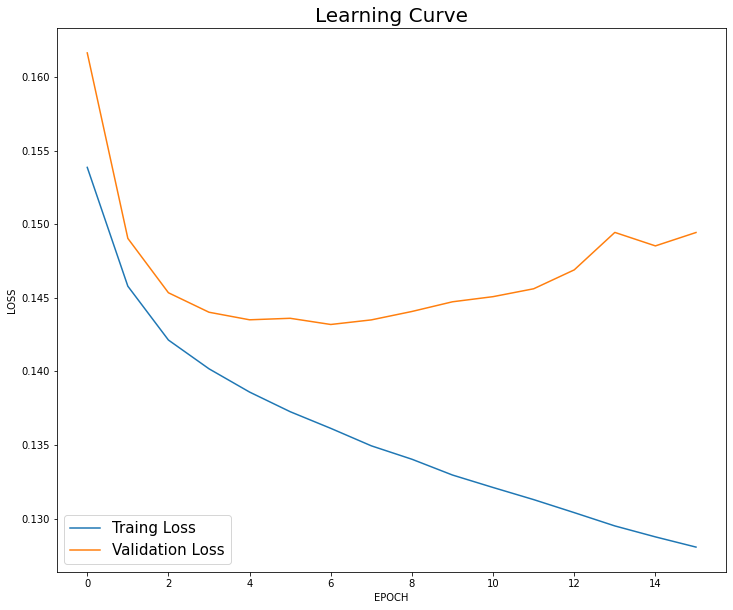

In [112]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss, label='Traing Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

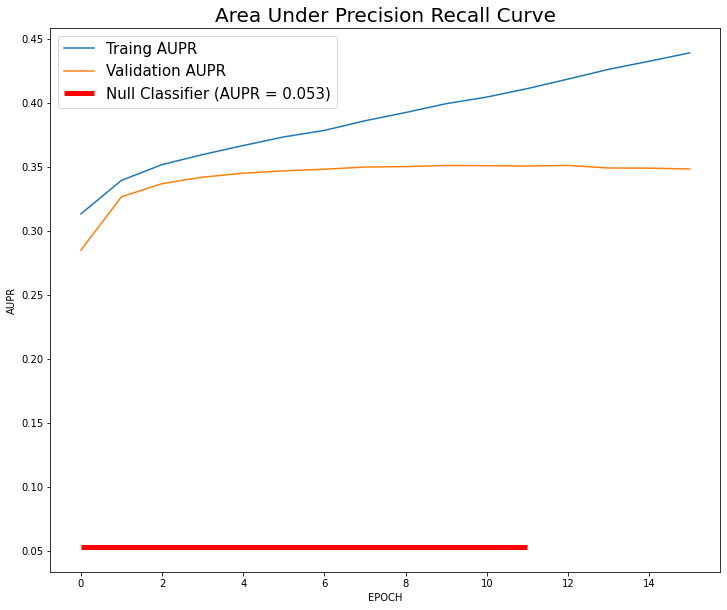

In [113]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr, label='Traing AUPR')
plt.plot(validation_aupr, label='Validation AUPR')
plt.hlines(0.053, 0.0, 11.0, colors='red', label="Null Classifier (AUPR = 0.053)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

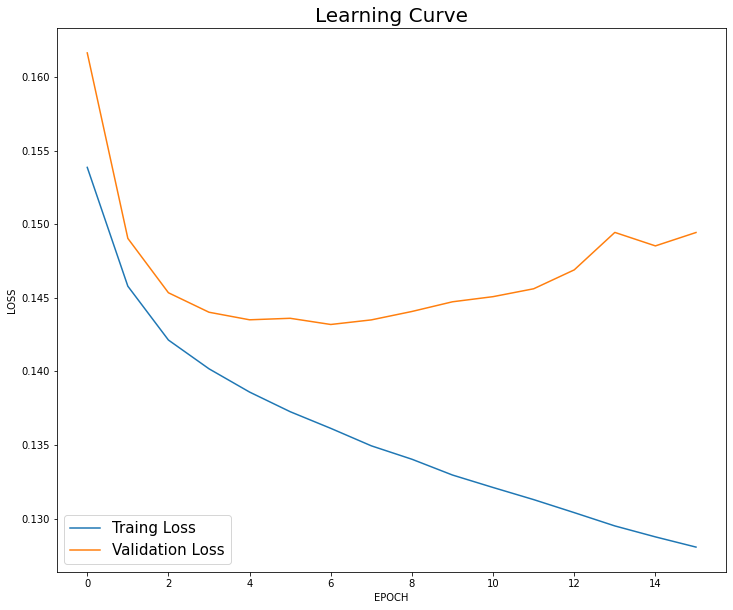

In [114]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss[:25], label='Traing Loss')
plt.plot(validation_loss[0:25], label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

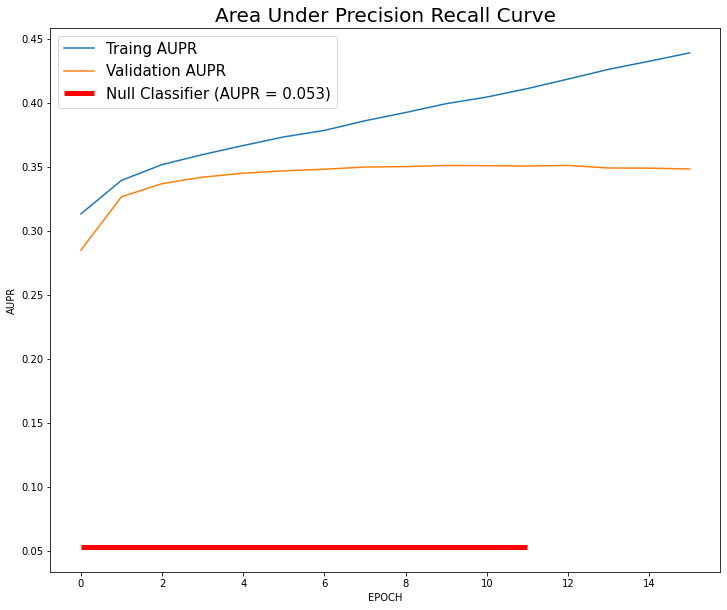

In [115]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr[:25], label='Traing AUPR')
plt.plot(validation_aupr[:25], label='Validation AUPR')
plt.hlines(0.053, 0.0, 11.0, colors='red', label="Null Classifier (AUPR = 0.053)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

In [116]:
def print_conversion_metrics(y_true, y_pred_classes, y_pred_probs, title):
    cmtx = pd.DataFrame(
    confusion_matrix(y_true=y_true, y_pred=y_pred_classes), 
                     index=['true: not converted', 'true: converted'], columns=['pred: not converted', 'pred: converted'])
    print(title)
    print(cmtx)
    print('\n')
    print(classification_report(y_true, y_pred_classes))
    print(f'The area under the PR curve is approximately {average_precision_score(y_true, y_pred_probs, pos_label=1):1.2f}')
    

In [117]:
predictions_train = model.predict([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']])
predicted_classes_train = np.where(predictions_train > 0.5, 1, 0)

In [118]:
print_conversion_metrics(y_train, predicted_classes_train, predictions_train, 'Training Results')

Training Results
                     pred: not converted  pred: converted
true: not converted  992073               5492           
true: converted      52891                6148           


              precision    recall  f1-score   support

           0       0.95      0.99      0.97    997565
           1       0.53      0.10      0.17     59039

    accuracy                           0.94   1056604
   macro avg       0.74      0.55      0.57   1056604
weighted avg       0.93      0.94      0.93   1056604

The area under the PR curve is approximately 0.39


#### Confusion matrix for training  is as expected

#### Now we create the confustion matrix for test

In [119]:
predictions_test = model.predict([data_dict['NAME_SENTENCE']['test'], 
           data_dict['ACTION_SENTENCE']['test'],
           data_dict['LABEL_SENTENCE']['test'],
           data_dict['DWELL_SENTENCE']['test']])


In [120]:
predicted_classes_test = np.where(predictions_test > 0.17, 1, 0)

In [121]:
print_conversion_metrics(y_test, predicted_classes_test, predictions_test, 'Test Results')

Test Results
                     pred: not converted  pred: converted
true: not converted  101314               9527           
true: converted      2012                 4548           


              precision    recall  f1-score   support

           0       0.98      0.91      0.95    110841
           1       0.32      0.69      0.44      6560

    accuracy                           0.90    117401
   macro avg       0.65      0.80      0.69    117401
weighted avg       0.94      0.90      0.92    117401

The area under the PR curve is approximately 0.36


### Now we slow things down by increasinng droput

In [122]:
def ClickStreamPageModel(input_shape):
    """
    Function creating the click stream model using page names per the graph above
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the model
    name_sentence_indices = Input(shape=input_shape, dtype='int32')
    action_sentence_indicies = Input(shape=input_shape, dtype='int32')
    label_sentence_indicies = Input(shape=input_shape, dtype='int32')
    dwell_sentence_indicies = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layers and propogate the input through these, then append these to create a 57 dimension input
    name_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(name_sentence_indices)
    action_emb = Embedding(input_dim=20001, output_dim=25, trainable=True, mask_zero=True)(action_sentence_indicies)
    label_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(label_sentence_indicies)
    dwell_emb = Embedding(input_dim=12, output_dim=2, trainable=True, mask_zero=True)(dwell_sentence_indicies)
    X = Concatenate()([name_emb, action_emb, label_emb, dwell_emb])
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units=128, return_sequences=True)(X)
    
    # Add dropout with a probability of 0.2
    X = Dropout(rate=0.2)(X)
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units=128, return_sequences=False)(X)
    
    # Add dropout with a probability of 0.2
    X = Dropout(rate=0.2)(X) 
    
    # Propagate X through a Dense layer with 1 unit
    X = Dense(units=1)(X)
    # Add a sigmod activation
    X = Activation('sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[name_sentence_indices, action_sentence_indicies, label_sentence_indicies, dwell_sentence_indicies], outputs=X)
    
    return model

In [123]:
model = ClickStreamPageModel(7)

In [124]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 7)]          0           []                               
                                                                                            

In [125]:
aupr = tensorflow.keras.metrics.AUC(
    num_thresholds=50,
    curve="PR",
    summation_method="interpolation",
    name='aupr',
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False,
)

### We define callbacks for early stopping and saving the best model

In [126]:
early_stopping_callback = tensorflow.keras.callbacks.EarlyStopping(
    monitor="val_aupr",
    min_delta=0,
    patience=4,
    verbose=0,
    mode="max",
    baseline=None,
    restore_best_weights=True,
)

In [127]:
model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-5), metrics=[aupr, 'accuracy'])

In [128]:
model.fit([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']],
           y_train, 
           callbacks=[early_stopping_callback],
           epochs = 100, 
           batch_size = 32, 
           shuffle=True, 
           validation_split=0.5)

Epoch 1/100
16510/16510 [==============================] - 565s 34ms/step - loss: 0.2598 - aupr: 0.0961 - accuracy: 0.9424 - val_loss: 0.1580 - val_aupr: 0.2994 - val_accuracy: 0.9417
Epoch 2/100
16510/16510 [==============================] - 554s 34ms/step - loss: 0.1503 - aupr: 0.3251 - accuracy: 0.9425 - val_loss: 0.1474 - val_aupr: 0.3322 - val_accuracy: 0.9427
Epoch 3/100
16510/16510 [==============================] - 555s 34ms/step - loss: 0.1438 - aupr: 0.3467 - accuracy: 0.9434 - val_loss: 0.1444 - val_aupr: 0.3408 - val_accuracy: 0.9430
Epoch 4/100
16510/16510 [==============================] - 554s 34ms/step - loss: 0.1408 - aupr: 0.3576 - accuracy: 0.9438 - val_loss: 0.1433 - val_aupr: 0.3452 - val_accuracy: 0.9434
Epoch 5/100
16510/16510 [==============================] - 554s 34ms/step - loss: 0.1388 - aupr: 0.3662 - accuracy: 0.9441 - val_loss: 0.1436 - val_aupr: 0.3469 - val_accuracy: 0.9437
Epoch 6/100
16510/16510 [==============================] - 555s 34ms/step - loss

In [129]:
training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']
training_aupr = model.history.history['aupr']
validation_aupr = model.history.history['val_aupr']

#### Remove the first item from the training list and the last item from the validation list.  This is due to the fact that reported training metrics are the mean of all the metrics in the epoch, but validation metrics are taken at the end of the epoch

In [130]:
validation_loss = validation_loss[:-1]

In [131]:
training_loss = training_loss[1:]

In [132]:
validation_aupr = validation_aupr[:-1]

In [133]:
training_aupr = training_aupr[1:]

In [134]:
len(validation_loss), len(training_loss), len(validation_aupr), len(training_aupr)

(12, 12, 12, 12)

In [135]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

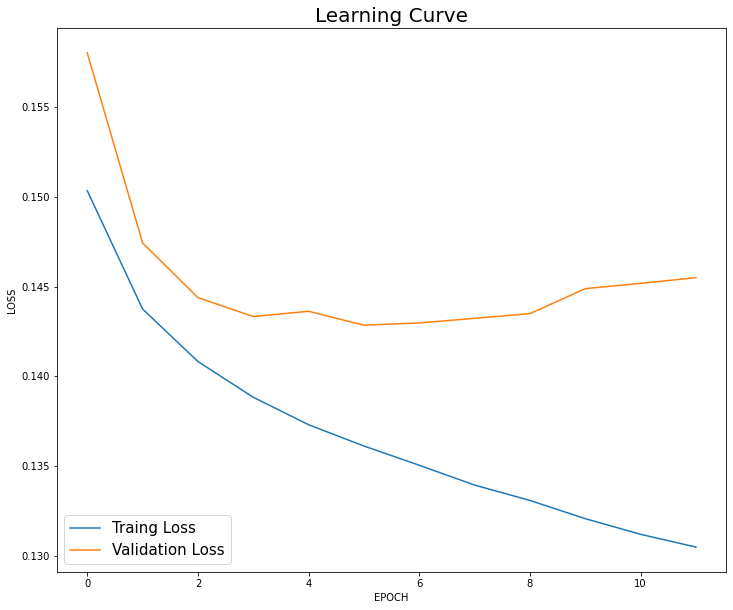

In [136]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss, label='Traing Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

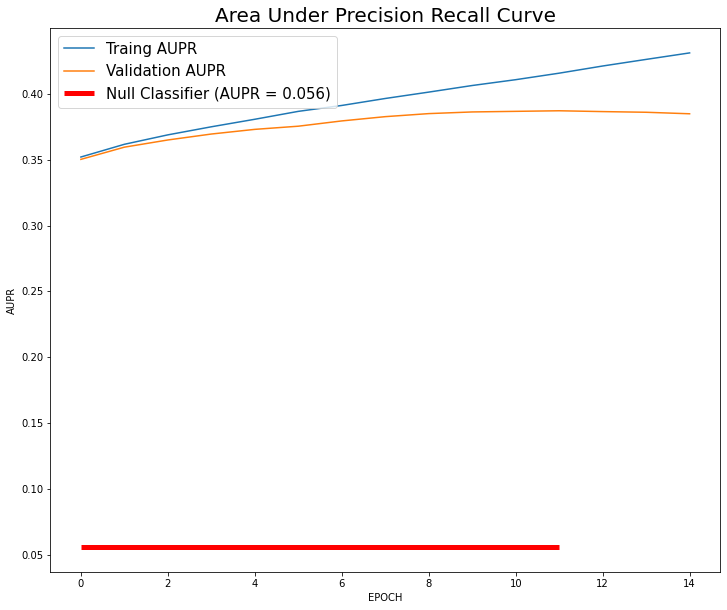

In [256]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr, label='Traing AUPR')
plt.plot(validation_aupr, label='Validation AUPR')
plt.hlines(0.056, 0.0, 11.0, colors='red', label="Null Classifier (AUPR = 0.056)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

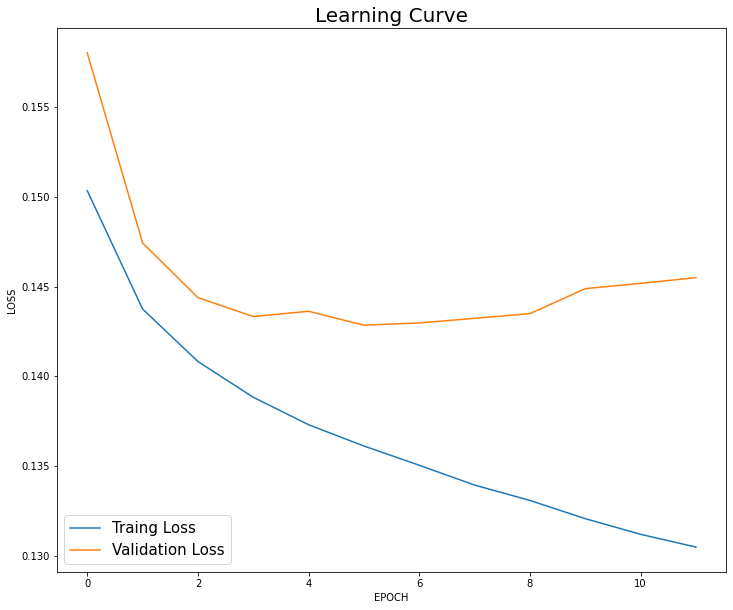

In [138]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss[:25], label='Traing Loss')
plt.plot(validation_loss[0:25], label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

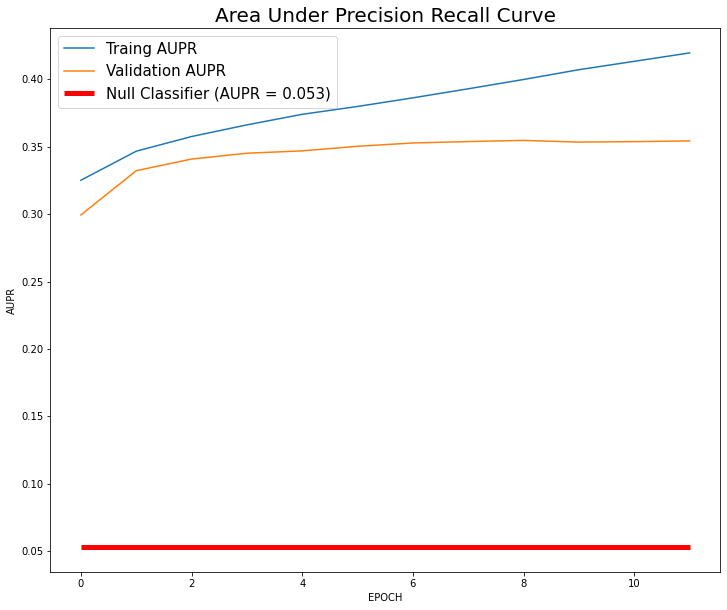

In [139]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr[:25], label='Traing AUPR')
plt.plot(validation_aupr[:25], label='Validation AUPR')
plt.hlines(0.053, 0.0, 11.0, colors='red', label="Null Classifier (AUPR = 0.053)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

In [140]:
def print_conversion_metrics(y_true, y_pred_classes, y_pred_probs, title):
    cmtx = pd.DataFrame(
    confusion_matrix(y_true=y_true, y_pred=y_pred_classes), 
                     index=['true: not converted', 'true: converted'], columns=['pred: not converted', 'pred: converted'])
    print(title)
    print(cmtx)
    print('\n')
    print(classification_report(y_true, y_pred_classes))
    print(f'The area under the PR curve is approximately {average_precision_score(y_true, y_pred_probs, pos_label=1):1.2f}')
    

In [141]:
predictions_train = model.predict([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']])
predicted_classes_train = np.where(predictions_train > 0.5, 1, 0)

In [142]:
print_conversion_metrics(y_train, predicted_classes_train, predictions_train, 'Training Results')

Training Results
                     pred: not converted  pred: converted
true: not converted  993145               4420           
true: converted      54091                4948           


              precision    recall  f1-score   support

           0       0.95      1.00      0.97    997565
           1       0.53      0.08      0.14     59039

    accuracy                           0.94   1056604
   macro avg       0.74      0.54      0.56   1056604
weighted avg       0.92      0.94      0.93   1056604

The area under the PR curve is approximately 0.38


#### Confusion matrix for training  is as expected

#### Now we create the confustion matrix for test

In [143]:
predictions_test = model.predict([data_dict['NAME_SENTENCE']['test'], 
           data_dict['ACTION_SENTENCE']['test'],
           data_dict['LABEL_SENTENCE']['test'],
           data_dict['DWELL_SENTENCE']['test']])


In [144]:
predicted_classes_test = np.where(predictions_test > 0.19, 1, 0)

In [145]:
print_conversion_metrics(y_test, predicted_classes_test, predictions_test, 'Test Results')

Test Results
                     pred: not converted  pred: converted
true: not converted  101518               9323           
true: converted      1997                 4563           


              precision    recall  f1-score   support

           0       0.98      0.92      0.95    110841
           1       0.33      0.70      0.45      6560

    accuracy                           0.90    117401
   macro avg       0.65      0.81      0.70    117401
weighted avg       0.94      0.90      0.92    117401

The area under the PR curve is approximately 0.37


### Now more data

# Now we  double our data size again and reset droput to 0.4

### Let's only  40% of the data

In [146]:
feature_table_subset = feature_table.groupby('LABEL').sample(frac=0.4, random_state=3)

In [147]:
len(feature_table), len(feature_table_subset)

(5870027, 2348011)

### Now split the data into train and test

In [148]:
X_train, X_test, y_train, y_test = train_test_split(feature_table_subset[['TYPE_SENTENCE', 'NAME_SENTENCE', 'CATEGORY_SENTENCE', 'ACTION_SENTENCE', 'LABEL_SENTENCE', 'DWELL_SENTENCE']], 
                                                    feature_table_subset['LABEL'], 
                                                    test_size=0.10, random_state=1, stratify=feature_table_subset['LABEL'])

In [149]:
X_train.head(10)

TYPE_SENTENCE  \
4243051  home, search, search, search                                                                                                     
5340521  home, search                                                                                                                     
5813914  PRODUCT, PRODUCT, PRODUCT, PRODUCT, PRODUCT, PRODUCT, PRODUCT, PRODUCT, PRODUCT, store, search, search, search, search, search   
267808   L2, L2, L2, L2, L2, L2, L2                                                                                                       
5581044  reactsearch, search, search, search                                                                                              
414914   home, store, home, home, home, home, Error                                                                                       
3885793  PRODUCT, PRODUCT, PRODUCT                                                                                                        
2554218  PRODUCT, PRODUCT, PRODUCT, PRODUCT, PRODUCT, search                                                                              
1523987  L3, L3                                                                                                                           
1708596  home, home, search, PRODUCT                                                                                                      

                                                                                                                                                                                                                                                                                                                                                            NAME_SENTENCE  \
4243051  Homepage, DoubleLeafBottomDoorRubberSealwithTChannelforTruckCapsMaResults, DoubleLeafBottomDoorRubberSealwithTChannelforResults, DoubleLeafBottomDoorRubberSealwitResults                                                                                                                                                                                          
5340521  Homepage, tierodResults                                                                                                                                                                                                                                                                                                                                            
5813914  ACCompressorwithClutch, HVACBlowerMotorResistor, HVACBlowerMotorResistor, HVACBlowerMotorResistor, HVACBlowerMotorResistor, HVACBlowerMotorResistor, HVACBlowerMotorResistor, HVACBlowerMotorResistor, HVACBlowerMotorResistor, StoreLocator, BlowermotorsensorResults, AcresistorResults, AcresistorResults, AcresistorsblowerResults, AcresistorsblowerResults   
267808   ACAccumulatorsampDriersResults, ACAccumulatorsampDriersResults, ACAccumulatorsampDriersResults, ACAccumulatorsampDriersResults, ACAccumulatorsampDriersResults, ACAccumulatorsampDriersResults, ACAccumulatorsampDriersResults                                                                                                                                     
5581044  reactsearch, FRAMoilResults, FRAMoilResults, FordoilResults                                                                                                                                                                                                                                                                                                        
414914   Homepage, BundleBuilder, Homepage, Homepage, Homepage, Homepage, Error                                                                                                                                                                                                                                                                                             
3885793  HubBearingAssembly, HubBeari

### Split data into list of labels and 5 lists of features

In [150]:
X_train_type = X_train['TYPE_SENTENCE'].tolist()
X_test_type = X_test['TYPE_SENTENCE'].tolist()
X_train_name = X_train['NAME_SENTENCE'].tolist()
X_test_name = X_test['NAME_SENTENCE'].tolist()
X_train_category = X_train['CATEGORY_SENTENCE'].tolist()
X_test_category = X_test['CATEGORY_SENTENCE'].tolist()
X_train_action = X_train['ACTION_SENTENCE'].tolist()
X_test_action = X_test['ACTION_SENTENCE'].tolist()
X_train_label = X_train['LABEL_SENTENCE'].tolist()
X_test_label = X_test['LABEL_SENTENCE'].tolist()
X_train_dwell = X_train['DWELL_SENTENCE'].tolist()
X_test_dwell = X_test['DWELL_SENTENCE'].tolist()

In [151]:
X_train_type[0]

'home, search, search, search'

In [152]:
X_train_name[0]

'Homepage, DoubleLeafBottomDoorRubberSealwithTChannelforTruckCapsMaResults, DoubleLeafBottomDoorRubberSealwithTChannelforResults, DoubleLeafBottomDoorRubberSealwitResults'

In [153]:
X_train_label[0]

'NoVehicle, NoVehicle, NoVehicle, LoadPage2'

In [154]:
X_train_dwell[0]

'60, 50, 60, 20'

In [155]:
y_train.head()

4243051    0
5340521    0
5813914    0
267808     0
5581044    0
Name: LABEL, dtype: int32

In [156]:
tokenizer = Tokenizer(
    num_words=400,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, 
    split=', ', 
    char_level=False, 
    oov_token="UNKNOWN")

### Prepare sequences for modeling.  Note that we pass the fit tokenizer when we prepare the test sequences

#### We create an empty dictionary.  The keys will be the sentence name, the values will be the train and test indicies

In [157]:
data_dict = {}

In [158]:
vocab_size_dict = {'TYPE_SENTENCE': 50,
                   'NAME_SENTENCE': 40000,
                   'CATEGORY_SENTENCE': 1900,
                   'ACTION_SENTENCE': 20000,
                   'LABEL_SENTENCE': 40000,
                   'DWELL_SENTENCE': 11
                  }

In [159]:
for column_name, size in vocab_size_dict.items():
    print(f'Starting {column_name} with size {size}')
    data_dict[column_name] = {}
    data_dict[column_name]['train'], fit_tokenizer = process_sentences(sentence_series=X_train[column_name], maxlen=7, num_words=size)
    data_dict[column_name]['test'], _ = process_sentences(sentence_series=X_test[column_name], maxlen=7, tokenizer=fit_tokenizer)
    

Starting TYPE_SENTENCE with size 50
Starting NAME_SENTENCE with size 40000
Starting CATEGORY_SENTENCE with size 1900
Starting ACTION_SENTENCE with size 20000
Starting LABEL_SENTENCE with size 40000
Starting DWELL_SENTENCE with size 11


In [160]:
data_dict['DWELL_SENTENCE']['train'][:10]

array([[ 0,  0,  0,  1,  8,  6,  9],
       [ 0,  0,  0,  0,  0,  1,  7],
       [ 1,  9,  3,  5, 10,  4,  3],
       [ 1,  8, 10, 10,  3, 10,  4],
       [ 0,  0,  0,  1,  6,  5,  9],
       [ 1,  2,  2,  7,  7,  6,  5],
       [ 0,  0,  0,  0,  1,  6,  5],
       [ 0,  1,  3,  5,  5,  6,  9],
       [ 0,  0,  0,  0,  0,  1,  6],
       [ 0,  0,  0,  1, 10,  6,  2]], dtype=int32)

In [161]:
data_dict['TYPE_SENTENCE']['train'][:10]

array([[ 0,  0,  0,  5,  2,  2,  2],
       [ 0,  0,  0,  0,  0,  5,  2],
       [ 7,  3,  3,  3,  3,  3,  3],
       [17, 14, 14, 14, 14, 14, 14],
       [ 0,  0,  0, 13,  2,  2,  2],
       [ 5,  9,  4,  4,  4,  4, 29],
       [ 0,  0,  0,  0,  7,  3,  3],
       [ 0,  7,  3,  3,  3,  3,  2],
       [ 0,  0,  0,  0,  0, 10,  6],
       [ 0,  0,  0,  5,  4,  2,  3]], dtype=int32)

In [162]:
data_dict['ACTION_SENTENCE']['train'][:10]

array([[   0,    0,    0,    1,    1,    1,    3],
       [   0,    0,    0,    0,    0,  606,    1],
       [  27,    7,    2,    2,    2,   12,   11],
       [  28,    8,    3,    3,   10,    8,    6],
       [   0,    0,    0,  170,    3,    1,    3],
       [  25,   35,   20,   36,   46,   36, 7015],
       [   0,    0,    0,    0,   23,    2,    2],
       [   0,   19,    2,    2,    2, 1103,    3],
       [   0,    0,    0,    0,    0,   15,    3],
       [   0,    0,    0,    1,   10,    6,    5]], dtype=int32)

In [163]:
data_dict['LABEL_SENTENCE']['train'][:10]

array([[    0,     0,     0,     6,     3,     3,     2],
       [    0,     0,     0,     0,     0,  1884,   211],
       [    6,     3,    12,     5,     7, 30930,     4],
       [  168,    13,     2,     8,    56,    13,     1],
       [    0,     0,     0,     6,     2,     3,     2],
       [   52,   102,    43,    29,    44,    29,     1],
       [    0,     0,     0,     0,   516,    14,     9],
       [    0,  3632,    12,     5,     7,   556,     2],
       [    0,     0,     0,     0,     0,    17,     2],
       [    0,     0,     0,     6,    23, 25536,     4]], dtype=int32)

In [164]:
data_dict['NAME_SENTENCE']['train'][:10]

array([[    0,     0,     0,     3,     1,     1,     1],
       [    0,     0,     0,     0,     0,     3,   169],
       [ 1193,   633,   633,   633,   633,   633,   633],
       [17726,  6594,  6594,  6594,  6594,  6594,  6594],
       [    0,     0,     0,     9,   135,   135, 29079],
       [    3,     8,     2,     2,     2,     2,   171],
       [    0,     0,     0,     0,   282,    85,    85],
       [    0,   755,   254,   254,   254,   254,  1513],
       [    0,     0,     0,     0,     0,   832,   144],
       [    0,     0,     0,     3,     2,     1,  2680]], dtype=int32)

In [165]:
data_dict['CATEGORY_SENTENCE']['train'][:10]

array([[ 0,  0,  0,  7,  4,  4,  2],
       [ 0,  0,  0,  0,  0,  7,  4],
       [ 9,  5,  3,  3,  3,  5,  5],
       [18, 10,  2,  2,  2, 10,  2],
       [ 0,  0,  0,  7,  2,  4,  2],
       [ 6, 20,  3,  3, 25,  3, 33],
       [ 0,  0,  0,  0,  9,  3,  3],
       [ 0,  9,  3,  3,  3,  4,  2],
       [ 0,  0,  0,  0,  0, 16,  2],
       [ 0,  0,  0,  7,  2,  2,  5]], dtype=int32)

### Our data is now fully prepared.  We now begin our modeling in keras

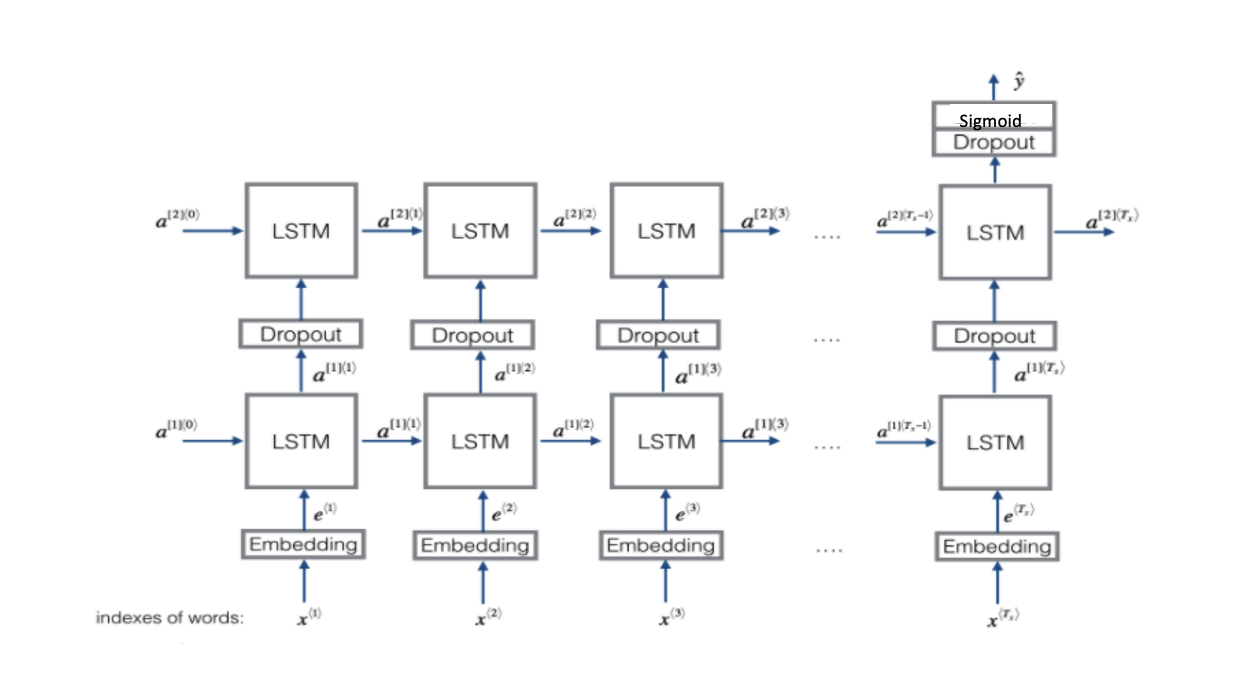

#### Above is our architecure.  We will add all layers in the architecure, but to start we will set dropout to 0.0 to start and try to minimze the training error

In [166]:
def ClickStreamPageModel(input_shape):
    """
    Function creating the click stream model using page names per the graph above
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the model
    name_sentence_indices = Input(shape=input_shape, dtype='int32')
    action_sentence_indicies = Input(shape=input_shape, dtype='int32')
    label_sentence_indicies = Input(shape=input_shape, dtype='int32')
    dwell_sentence_indicies = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layers and propogate the input through these, then append these to create a 57 dimension input
    name_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(name_sentence_indices)
    action_emb = Embedding(input_dim=20001, output_dim=25, trainable=True, mask_zero=True)(action_sentence_indicies)
    label_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(label_sentence_indicies)
    dwell_emb = Embedding(input_dim=12, output_dim=2, trainable=True, mask_zero=True)(dwell_sentence_indicies)
    X = Concatenate()([name_emb, action_emb, label_emb, dwell_emb])
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units=128, return_sequences=True)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X)
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units=128, return_sequences=False)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X) 
    
    # Propagate X through a Dense layer with 1 unit
    X = Dense(units=1)(X)
    # Add a sigmod activation
    X = Activation('sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[name_sentence_indices, action_sentence_indicies, label_sentence_indicies, dwell_sentence_indicies], outputs=X)
    
    return model

In [167]:
model = ClickStreamPageModel(7)

In [168]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 7)]          0           []                               
                                                                                            

In [169]:
aupr = tensorflow.keras.metrics.AUC(
    num_thresholds=50,
    curve="PR",
    summation_method="interpolation",
    name='aupr',
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False,
)

### We define callbacks for early stopping and saving the best model

In [170]:
early_stopping_callback = tensorflow.keras.callbacks.EarlyStopping(
    monitor="val_aupr",
    min_delta=0,
    patience=4,
    verbose=0,
    mode="max",
    baseline=None,
    restore_best_weights=True,
)

In [171]:
model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-5), metrics=[aupr, 'accuracy'])

In [172]:
model.fit([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']],
           y_train, 
           callbacks=[early_stopping_callback],
           epochs = 100, 
           batch_size = 32, 
           shuffle=True, 
           validation_split=0.5)

Epoch 1/100
33019/33019 [==============================] - 1116s 34ms/step - loss: 0.2092 - aupr: 0.1484 - accuracy: 0.9422 - val_loss: 0.1478 - val_aupr: 0.3326 - val_accuracy: 0.9424
Epoch 2/100
33019/33019 [==============================] - 1109s 34ms/step - loss: 0.1455 - aupr: 0.3362 - accuracy: 0.9431 - val_loss: 0.1431 - val_aupr: 0.3467 - val_accuracy: 0.9434
Epoch 3/100
33019/33019 [==============================] - 1110s 34ms/step - loss: 0.1420 - aupr: 0.3483 - accuracy: 0.9436 - val_loss: 0.1424 - val_aupr: 0.3522 - val_accuracy: 0.9438
Epoch 4/100
33019/33019 [==============================] - 1109s 34ms/step - loss: 0.1404 - aupr: 0.3556 - accuracy: 0.9440 - val_loss: 0.1419 - val_aupr: 0.3550 - val_accuracy: 0.9440
Epoch 5/100
33019/33019 [==============================] - 1108s 34ms/step - loss: 0.1393 - aupr: 0.3630 - accuracy: 0.9442 - val_loss: 0.1417 - val_aupr: 0.3577 - val_accuracy: 0.9441
Epoch 6/100
33019/33019 [==============================] - 1108s 34ms/step 

In [173]:
training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']
training_aupr = model.history.history['aupr']
validation_aupr = model.history.history['val_aupr']

#### Remove the first item from the training list and the last item from the validation list.  This is due to the fact that reported training metrics are the mean of all the metrics in the epoch, but validation metrics are taken at the end of the epoch

In [174]:
validation_loss = validation_loss[:-1]

In [175]:
training_loss = training_loss[1:]

In [176]:
validation_aupr = validation_aupr[:-1]

In [177]:
training_aupr = training_aupr[1:]

In [178]:
len(validation_loss), len(training_loss), len(validation_aupr), len(training_aupr)

(20, 20, 20, 20)

In [179]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

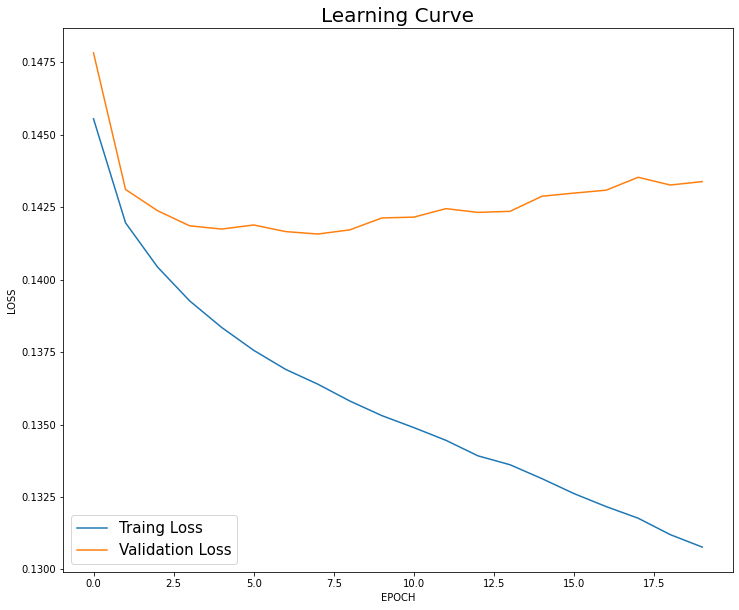

In [180]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss, label='Traing Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

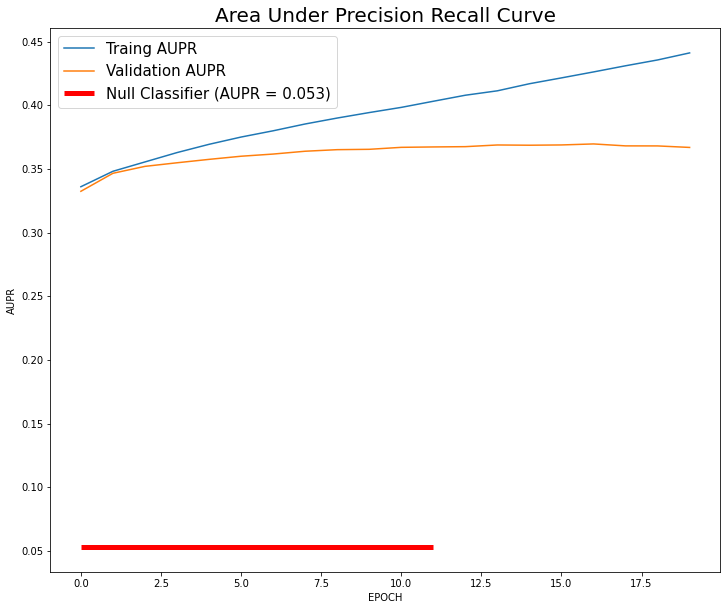

In [181]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr, label='Traing AUPR')
plt.plot(validation_aupr, label='Validation AUPR')
plt.hlines(0.053, 0.0, 11.0, colors='red', label="Null Classifier (AUPR = 0.053)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

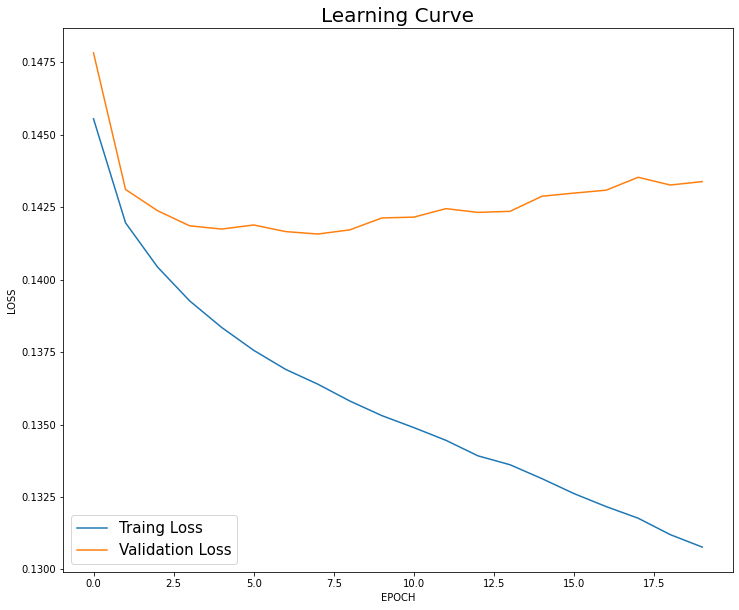

In [182]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss[:25], label='Traing Loss')
plt.plot(validation_loss[0:25], label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

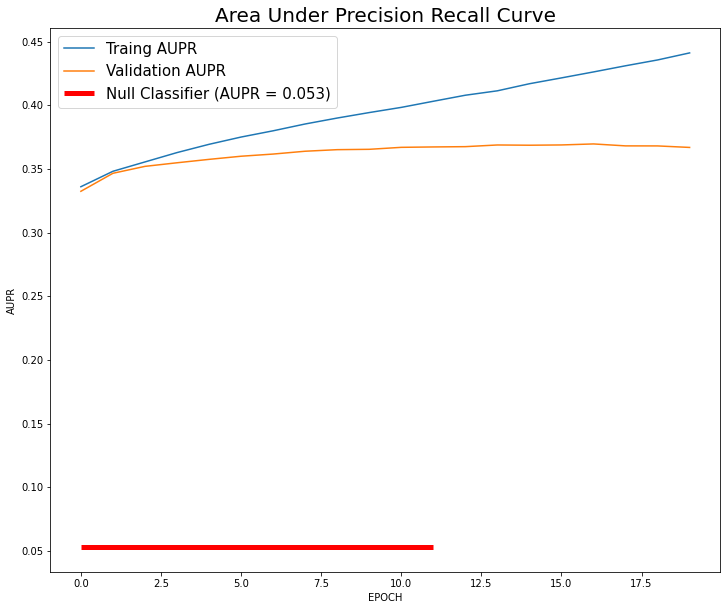

In [183]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr[:25], label='Traing AUPR')
plt.plot(validation_aupr[:25], label='Validation AUPR')
plt.hlines(0.053, 0.0, 11.0, colors='red', label="Null Classifier (AUPR = 0.053)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

In [184]:
def print_conversion_metrics(y_true, y_pred_classes, y_pred_probs, title):
    cmtx = pd.DataFrame(
    confusion_matrix(y_true=y_true, y_pred=y_pred_classes), 
                     index=['true: not converted', 'true: converted'], columns=['pred: not converted', 'pred: converted'])
    print(title)
    print(cmtx)
    print('\n')
    print(classification_report(y_true, y_pred_classes))
    print(f'The area under the PR curve is approximately {average_precision_score(y_true, y_pred_probs, pos_label=1):1.2f}')
    

In [185]:
predictions_train = model.predict([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']])
predicted_classes_train = np.where(predictions_train > 0.5, 1, 0)

In [186]:
print_conversion_metrics(y_train, predicted_classes_train, predictions_train, 'Training Results')

Training Results
                     pred: not converted  pred: converted
true: not converted  1984423              10707          
true: converted      104113               13966          


              precision    recall  f1-score   support

           0       0.95      0.99      0.97   1995130
           1       0.57      0.12      0.20    118079

    accuracy                           0.95   2113209
   macro avg       0.76      0.56      0.58   2113209
weighted avg       0.93      0.95      0.93   2113209

The area under the PR curve is approximately 0.40


#### Confusion matrix for training  is as expected

#### Now we create the confustion matrix for test

In [187]:
predictions_test = model.predict([data_dict['NAME_SENTENCE']['test'], 
           data_dict['ACTION_SENTENCE']['test'],
           data_dict['LABEL_SENTENCE']['test'],
           data_dict['DWELL_SENTENCE']['test']])


In [188]:
predicted_classes_test = np.where(predictions_test > 0.18, 1, 0)

In [189]:
print_conversion_metrics(y_test, predicted_classes_test, predictions_test, 'Test Results')

Test Results
                     pred: not converted  pred: converted
true: not converted  203913               17769          
true: converted      4339                 8781           


              precision    recall  f1-score   support

           0       0.98      0.92      0.95    221682
           1       0.33      0.67      0.44     13120

    accuracy                           0.91    234802
   macro avg       0.65      0.79      0.70    234802
weighted avg       0.94      0.91      0.92    234802

The area under the PR curve is approximately 0.37


### Now we use all the data

In [190]:
feature_table_subset = feature_table

In [191]:
len(feature_table), len(feature_table_subset)

(5870027, 5870027)

### Now split the data into train and test

In [192]:
X_train, X_test, y_train, y_test = train_test_split(feature_table_subset[['TYPE_SENTENCE', 'NAME_SENTENCE', 'CATEGORY_SENTENCE', 'ACTION_SENTENCE', 'LABEL_SENTENCE', 'DWELL_SENTENCE']], 
                                                    feature_table_subset['LABEL'], 
                                                    test_size=0.10, random_state=1, stratify=feature_table_subset['LABEL'])

In [193]:
X_train.head(10)

TYPE_SENTENCE  \
392064   home, search                                                                                                              
2035363  L3                                                                                                                        
251490   reactsearch, search, search, search, search, search, search, search, search, search, store, reactsearch, search, search   
1226420  home                                                                                                                      
2238068  PRODUCT                                                                                                                   
3500564  store, store, store, store, store, store, store, store, store, PRODUCT, reactsearch                                       
976236   home, home                                                                                                                
3237243  L3                                                                                                                        
4899000  home, search, search, reactsearch, search                                                                                 
3104989  store, home, home, home                                                                                                   

                                                                                                                                                                                                                                                                                                                             NAME_SENTENCE  \
392064   Homepage, belttensionerpulleyResults                                                                                                                                                                                                                                                                                                
2035363  StrutsampShockAbsorbersResults                                                                                                                                                                                                                                                                                                      
251490   reactsearch, innova3100diagnostictoolResults, innova3100diagnostictoolResults, innova3100diagnostictoolResults, diagnostictoolResults, diagnostictoolResults, diagnostictoolResults, diagnostictoolResults, diagnostictoolResults, diagnostictoolResults, StoreDetails, reactsearch, diagnostictoolResults, diagnostictoolResults   
1226420  Homepage                                                                                                                                                                                                                                                                                                                            
2238068  FrontDriverSideWindowRegulatorwithoutMotor                                                                                                                                                                                                                                                                                          
3500564  BundleBuilder, BundleBuilder, BundleBuilder, BundleBuilder, BundleBuilder, BundleBuilder, BundleBuilder, BundleBuilder, BundleBuilder, TitaniumSpinOnOilFilter, reactsearch                                                                                                                                                         
976236   Homepage, Homepage                                                                                                                                                                                                                                                                                                         

### Split data into list of labels and 5 lists of features

In [194]:
X_train_type = X_train['TYPE_SENTENCE'].tolist()
X_test_type = X_test['TYPE_SENTENCE'].tolist()
X_train_name = X_train['NAME_SENTENCE'].tolist()
X_test_name = X_test['NAME_SENTENCE'].tolist()
X_train_category = X_train['CATEGORY_SENTENCE'].tolist()
X_test_category = X_test['CATEGORY_SENTENCE'].tolist()
X_train_action = X_train['ACTION_SENTENCE'].tolist()
X_test_action = X_test['ACTION_SENTENCE'].tolist()
X_train_label = X_train['LABEL_SENTENCE'].tolist()
X_test_label = X_test['LABEL_SENTENCE'].tolist()
X_train_dwell = X_train['DWELL_SENTENCE'].tolist()
X_test_dwell = X_test['DWELL_SENTENCE'].tolist()

In [195]:
X_train_type[0]

'home, search'

In [196]:
X_train_name[0]

'Homepage, belttensionerpulleyResults'

In [197]:
X_train_label[0]

'NoVehicle, LoadPage2'

In [198]:
X_train_dwell[0]

'50, 20'

In [199]:
y_train.head()

392064     0
2035363    0
251490     0
1226420    0
2238068    0
Name: LABEL, dtype: int32

In [200]:
tokenizer = Tokenizer(
    num_words=400,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, 
    split=', ', 
    char_level=False, 
    oov_token="UNKNOWN")

### Prepare sequences for modeling.  Note that we pass the fit tokenizer when we prepare the test sequences

#### We create an empty dictionary.  The keys will be the sentence name, the values will be the train and test indicies

In [201]:
data_dict = {}

In [202]:
vocab_size_dict = {'TYPE_SENTENCE': 50,
                   'NAME_SENTENCE': 40000,
                   'CATEGORY_SENTENCE': 1900,
                   'ACTION_SENTENCE': 20000,
                   'LABEL_SENTENCE': 40000,
                   'DWELL_SENTENCE': 11
                  }

In [203]:
for column_name, size in vocab_size_dict.items():
    print(f'Starting {column_name} with size {size}')
    data_dict[column_name] = {}
    data_dict[column_name]['train'], fit_tokenizer = process_sentences(sentence_series=X_train[column_name], maxlen=7, num_words=size)
    data_dict[column_name]['test'], _ = process_sentences(sentence_series=X_test[column_name], maxlen=7, tokenizer=fit_tokenizer)
    

Starting TYPE_SENTENCE with size 50
Starting NAME_SENTENCE with size 40000
Starting CATEGORY_SENTENCE with size 1900
Starting ACTION_SENTENCE with size 20000
Starting LABEL_SENTENCE with size 40000
Starting DWELL_SENTENCE with size 11


In [204]:
data_dict['DWELL_SENTENCE']['train'][:10]

array([[ 0,  0,  0,  0,  0,  1,  9],
       [ 0,  0,  0,  0,  0,  0,  1],
       [ 1, 10,  9,  2,  3,  7,  6],
       [ 0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  1],
       [ 1,  8,  9,  9,  6,  8,  2],
       [ 0,  0,  0,  0,  0,  1,  4],
       [ 0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  1,  3,  7, 10, 10],
       [ 0,  0,  0,  1, 10,  8,  6]], dtype=int32)

In [205]:
data_dict['TYPE_SENTENCE']['train'][:10]

array([[ 0,  0,  0,  0,  0,  5,  2],
       [ 0,  0,  0,  0,  0,  0, 10],
       [13,  2,  2,  2,  2,  2,  2],
       [ 0,  0,  0,  0,  0,  0,  5],
       [ 0,  0,  0,  0,  0,  0,  7],
       [17,  9,  9,  9,  9,  9,  9],
       [ 0,  0,  0,  0,  0,  5,  4],
       [ 0,  0,  0,  0,  0,  0, 10],
       [ 0,  0,  5,  2,  2,  8,  2],
       [ 0,  0,  0, 17,  4,  4,  4]], dtype=int32)

In [206]:
data_dict['ACTION_SENTENCE']['train'][:10]

array([[   0,    0,    0,    0,    0,  890,    3],
       [   0,    0,    0,    0,    0,    0, 1044],
       [   1,    3,    1,    1,    3,    3,    8],
       [   0,    0,    0,    0,    0,    0, 1267],
       [   0,    0,    0,    0,    0,    0,    1],
       [1212,   35,   44,   43,   29,   53,    2],
       [   0,    0,    0,    0,    0,    4,    2],
       [   0,    0,    0,    0,    0,    0,   28],
       [   0,    0, 1722,    3,    3,  975,    3],
       [   0,    0,    0,   87,    2,    2, 1698]], dtype=int32)

In [207]:
data_dict['LABEL_SENTENCE']['train'][:10]

array([[    0,     0,     0,     0,     0,     6,     2],
       [    0,     0,     0,     0,     0,     0,  1012],
       [    6,     2,     3,     3,     2,     8,  3892],
       [    0,     0,     0,     0,     0,     0,     1],
       [    0,     0,     0,     0,     0,     0, 10788],
       [ 1394,   105,   214,   667,     1,   189,    34],
       [    0,     0,     0,     0,     0,    12,    40],
       [    0,     0,     0,     0,     0,     0,    38],
       [    0,     0,     6,     2,     8,     3,     2],
       [    0,     0,     0,    79,    14,     9,  1905]], dtype=int32)

In [208]:
data_dict['NAME_SENTENCE']['train'][:10]

array([[    0,     0,     0,     0,     0,     3,   348],
       [    0,     0,     0,     0,     0,     0,   602],
       [    9,     1,     1,     1, 25593, 25593, 25593],
       [    0,     0,     0,     0,     0,     0,     3],
       [    0,     0,     0,     0,     0,     0,  1941],
       [   35,     8,     8,     8,     8,     8,     8],
       [    0,     0,     0,     0,     0,     3,     2],
       [    0,     0,     0,     0,     0,     0,  3869],
       [    0,     0,     3,  1256,  1256,     4,  5439],
       [    0,     0,     0,    35,     2,     2,     2]], dtype=int32)

In [209]:
data_dict['CATEGORY_SENTENCE']['train'][:10]

array([[ 0,  0,  0,  0,  0, 14,  2],
       [ 0,  0,  0,  0,  0,  0,  7],
       [ 7,  2,  4,  4,  2,  2, 10],
       [ 0,  0,  0,  0,  0,  0,  7],
       [ 0,  0,  0,  0,  0,  0,  7],
       [27, 20, 20, 21, 20, 21,  3],
       [ 0,  0,  0,  0,  0,  6, 13],
       [ 0,  0,  0,  0,  0,  0, 18],
       [ 0,  0,  7,  2,  2,  4,  2],
       [ 0,  0,  0, 27,  3,  3, 12]], dtype=int32)

### Our data is now fully prepared.  We now begin our modeling in keras

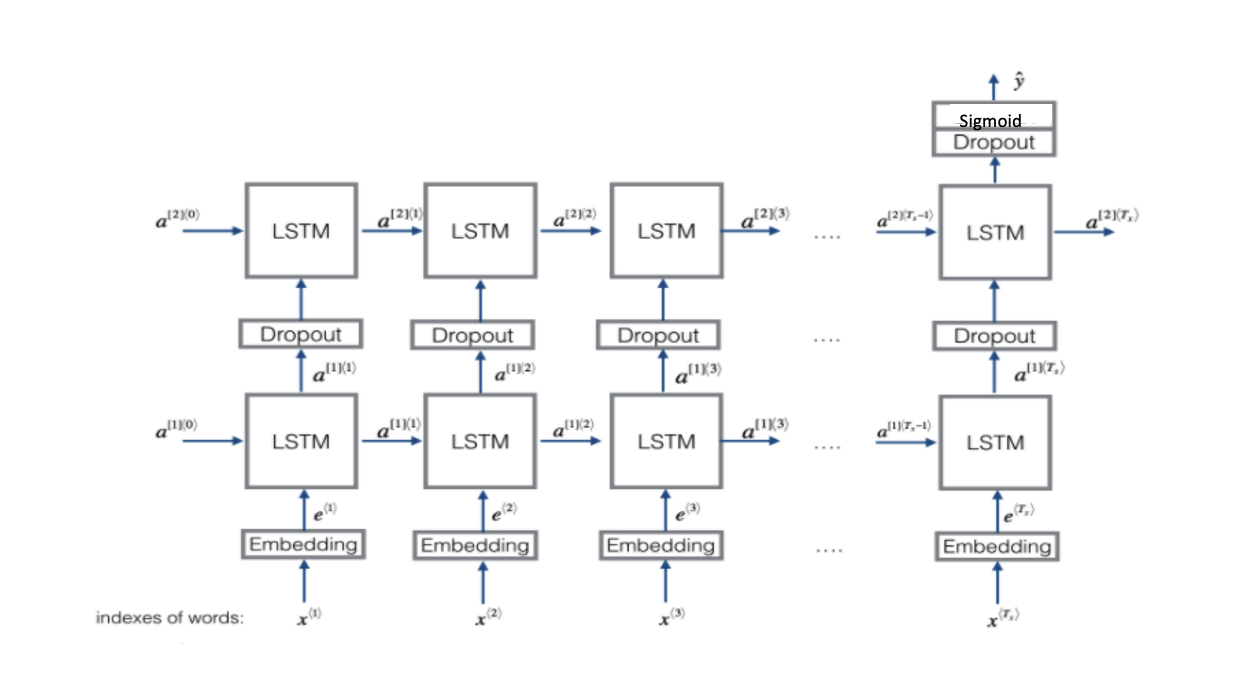

#### Above is our architecure.  We will add all layers in the architecure, but to start we will set dropout to 0.0 to start and try to minimze the training error

In [210]:
def ClickStreamPageModel(input_shape):
    """
    Function creating the click stream model using page names per the graph above
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the model
    name_sentence_indices = Input(shape=input_shape, dtype='int32')
    action_sentence_indicies = Input(shape=input_shape, dtype='int32')
    label_sentence_indicies = Input(shape=input_shape, dtype='int32')
    dwell_sentence_indicies = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layers and propogate the input through these, then append these to create a 57 dimension input
    name_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(name_sentence_indices)
    action_emb = Embedding(input_dim=20001, output_dim=25, trainable=True, mask_zero=True)(action_sentence_indicies)
    label_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(label_sentence_indicies)
    dwell_emb = Embedding(input_dim=12, output_dim=2, trainable=True, mask_zero=True)(dwell_sentence_indicies)
    X = Concatenate()([name_emb, action_emb, label_emb, dwell_emb])
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units=128, return_sequences=True)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X)
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units=128, return_sequences=False)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X) 
    
    # Propagate X through a Dense layer with 1 unit
    X = Dense(units=1)(X)
    # Add a sigmod activation
    X = Activation('sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[name_sentence_indices, action_sentence_indicies, label_sentence_indicies, dwell_sentence_indicies], outputs=X)
    
    return model

In [211]:
model = ClickStreamPageModel(7)

In [212]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 7)]          0           []                               
                                                                                            

In [213]:
aupr = tensorflow.keras.metrics.AUC(
    num_thresholds=50,
    curve="PR",
    summation_method="interpolation",
    name='aupr',
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False,
)

### We define callbacks for early stopping and saving the best model

In [214]:
early_stopping_callback = tensorflow.keras.callbacks.EarlyStopping(
    monitor="val_aupr",
    min_delta=0,
    patience=4,
    verbose=0,
    mode="max",
    baseline=None,
    restore_best_weights=True,
)

In [215]:
model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-5), metrics=[aupr, 'accuracy'])

In [216]:
model.fit([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']],
           y_train, 
           callbacks=[early_stopping_callback],
           epochs = 100, 
           batch_size = 32, 
           shuffle=True, 
           validation_split=0.5)

Epoch 1/100
82548/82548 [==============================] - 2776s 34ms/step - loss: 0.1701 - aupr: 0.2333 - accuracy: 0.9427 - val_loss: 0.1421 - val_aupr: 0.3502 - val_accuracy: 0.9436
Epoch 2/100
82548/82548 [==============================] - 2770s 34ms/step - loss: 0.1416 - aupr: 0.3520 - accuracy: 0.9439 - val_loss: 0.1406 - val_aupr: 0.3595 - val_accuracy: 0.9440
Epoch 3/100
82548/82548 [==============================] - 2771s 34ms/step - loss: 0.1402 - aupr: 0.3617 - accuracy: 0.9442 - val_loss: 0.1401 - val_aupr: 0.3649 - val_accuracy: 0.9442
Epoch 4/100
82548/82548 [==============================] - 2771s 34ms/step - loss: 0.1393 - aupr: 0.3688 - accuracy: 0.9444 - val_loss: 0.1401 - val_aupr: 0.3694 - val_accuracy: 0.9443
Epoch 5/100
82548/82548 [==============================] - 2771s 34ms/step - loss: 0.1387 - aupr: 0.3749 - accuracy: 0.9446 - val_loss: 0.1397 - val_aupr: 0.3730 - val_accuracy: 0.9445
Epoch 6/100
82548/82548 [==============================] - 2772s 34ms/step 

In [217]:
training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']
training_aupr = model.history.history['aupr']
validation_aupr = model.history.history['val_aupr']

#### Remove the first item from the training list and the last item from the validation list.  This is due to the fact that reported training metrics are the mean of all the metrics in the epoch, but validation metrics are taken at the end of the epoch

In [218]:
validation_loss = validation_loss[:-1]

In [219]:
training_loss = training_loss[1:]

In [220]:
validation_aupr = validation_aupr[:-1]

In [221]:
training_aupr = training_aupr[1:]

In [222]:
len(validation_loss), len(training_loss), len(validation_aupr), len(training_aupr)

(15, 15, 15, 15)

In [223]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

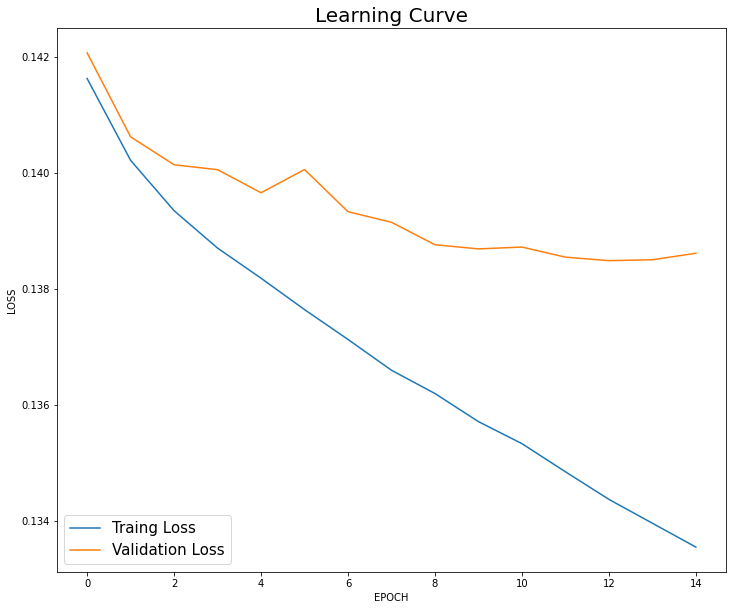

In [224]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss, label='Traing Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

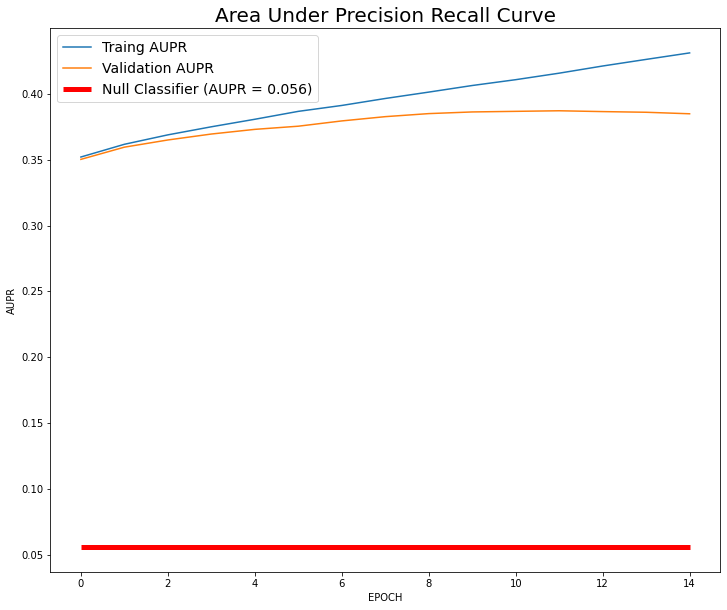

In [263]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr, label='Traing AUPR')
plt.plot(validation_aupr, label='Validation AUPR')
plt.hlines(0.056, 0.0, 14.0, colors='red', label="Null Classifier (AUPR = 0.056)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=14)

In [264]:
validation_aupr

[0.3502184748649597,
 0.35947519540786743,
 0.3649349808692932,
 0.3694431483745575,
 0.37298673391342163,
 0.3753860294818878,
 0.37939319014549255,
 0.3826318085193634,
 0.3849436342716217,
 0.386204332113266,
 0.3866615891456604,
 0.3870963752269745,
 0.386473149061203,
 0.3859621286392212,
 0.3848155736923218]

In [228]:
def print_conversion_metrics(y_true, y_pred_classes, y_pred_probs, title):
    cmtx = pd.DataFrame(
    confusion_matrix(y_true=y_true, y_pred=y_pred_classes), 
                     index=['true: not converted', 'true: converted'], columns=['pred: not converted', 'pred: converted'])
    print(title)
    print(cmtx)
    print('\n')
    print(classification_report(y_true, y_pred_classes))
    print(f'The area under the PR curve is approximately {average_precision_score(y_true, y_pred_probs, pos_label=1):1.2f}')
    

In [229]:
predictions_train = model.predict([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']])
predicted_classes_train = np.where(predictions_train > 0.5, 1, 0)

In [230]:
print_conversion_metrics(y_train, predicted_classes_train, predictions_train, 'Training Results')

Training Results
                     pred: not converted  pred: converted
true: not converted  4965719              22108          
true: converted      264478               30719          


              precision    recall  f1-score   support

           0       0.95      1.00      0.97   4987827
           1       0.58      0.10      0.18    295197

    accuracy                           0.95   5283024
   macro avg       0.77      0.55      0.57   5283024
weighted avg       0.93      0.95      0.93   5283024

The area under the PR curve is approximately 0.41


#### Confusion matrix for training  is as expected

#### Now we create the confustion matrix for test

In [231]:
predictions_test = model.predict([data_dict['NAME_SENTENCE']['test'], 
           data_dict['ACTION_SENTENCE']['test'],
           data_dict['LABEL_SENTENCE']['test'],
           data_dict['DWELL_SENTENCE']['test']])


In [252]:
predicted_classes_test = np.where(predictions_test > 0.325, 1, 0)

In [253]:
print_conversion_metrics(y_test, predicted_classes_test, predictions_test, 'Test Results')

Test Results
                     pred: not converted  pred: converted
true: not converted  535496               18707          
true: converted      19196                13604          


              precision    recall  f1-score   support

           0       0.97      0.97      0.97    554203
           1       0.42      0.41      0.42     32800

    accuracy                           0.94    587003
   macro avg       0.69      0.69      0.69    587003
weighted avg       0.93      0.94      0.94    587003

The area under the PR curve is approximately 0.39


# Now we use all the data and slow the learning rate

### Now we use all the data

In [14]:
feature_table_subset = feature_table

In [15]:
len(feature_table), len(feature_table_subset)

(5870027, 5870027)

### Now split the data into train and test

In [16]:
X_train, X_test, y_train, y_test = train_test_split(feature_table_subset[['TYPE_SENTENCE', 'NAME_SENTENCE', 'CATEGORY_SENTENCE', 'ACTION_SENTENCE', 'LABEL_SENTENCE', 'DWELL_SENTENCE']], 
                                                    feature_table_subset['LABEL'], 
                                                    test_size=0.10, random_state=1, stratify=feature_table_subset['LABEL'])

### Prepare sequences for modeling.  Note that we pass the fit tokenizer when we prepare the test sequences

#### We create an empty dictionary.  The keys will be the sentence name, the values will be the train and test indicies

In [17]:
data_dict = {}

In [18]:
vocab_size_dict = {'TYPE_SENTENCE': 50,
                   'NAME_SENTENCE': 40000,
                   'CATEGORY_SENTENCE': 1900,
                   'ACTION_SENTENCE': 20000,
                   'LABEL_SENTENCE': 40000,
                   'DWELL_SENTENCE': 11
                  }

In [ ]:
for column_name, size in vocab_size_dict.items():
    print(f'Starting {column_name} with size {size}')
    data_dict[column_name] = {}
    data_dict[column_name]['train'], fit_tokenizer = process_sentences(sentence_series=X_train[column_name], maxlen=7, num_words=size)
    data_dict[column_name]['test'], _ = process_sentences(sentence_series=X_test[column_name], maxlen=7, tokenizer=fit_tokenizer)
    

Starting TYPE_SENTENCE with size 50
Starting NAME_SENTENCE with size 40000
Starting CATEGORY_SENTENCE with size 1900
Starting ACTION_SENTENCE with size 20000


### Our data is now fully prepared.  We now begin our modeling in keras

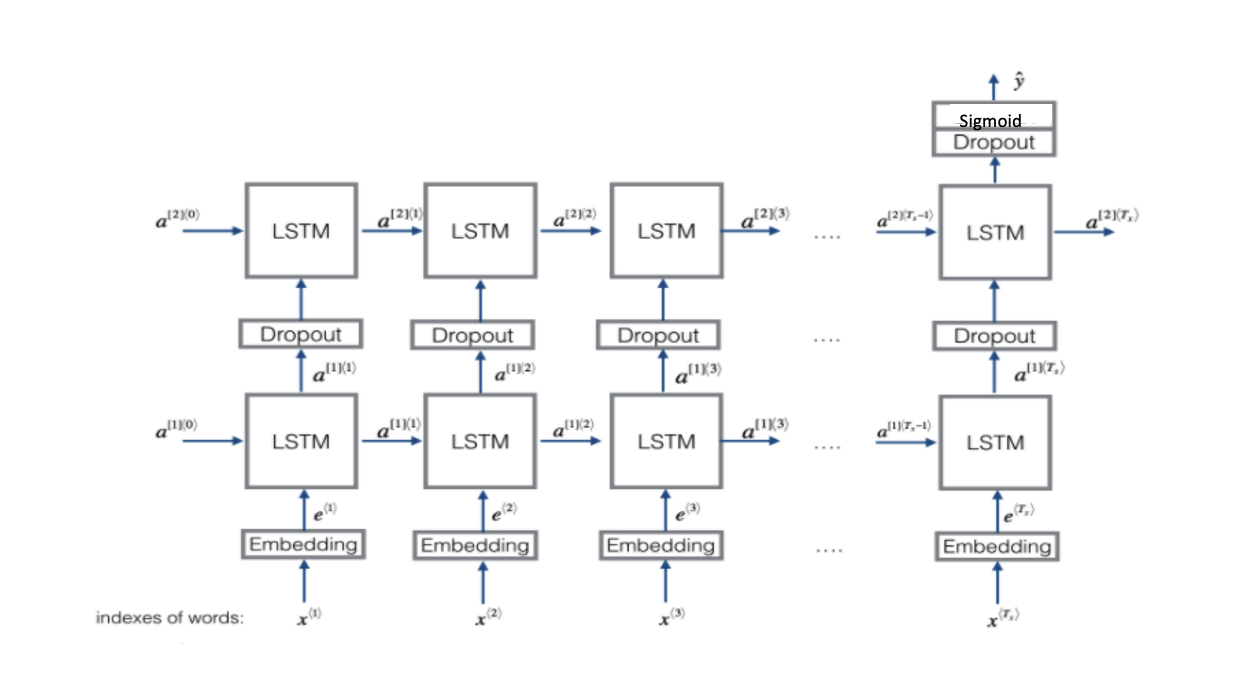

#### Above is our architecure.  We will add all layers in the architecure, but to start we will set dropout to 0.0 to start and try to minimze the training error

In [271]:
def ClickStreamPageModel(input_shape):
    """
    Function creating the click stream model using page names per the graph above
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the model
    name_sentence_indices = Input(shape=input_shape, dtype='int32')
    action_sentence_indicies = Input(shape=input_shape, dtype='int32')
    label_sentence_indicies = Input(shape=input_shape, dtype='int32')
    dwell_sentence_indicies = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layers and propogate the input through these, then append these to create a 57 dimension input
    name_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(name_sentence_indices)
    action_emb = Embedding(input_dim=20001, output_dim=25, trainable=True, mask_zero=True)(action_sentence_indicies)
    label_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(label_sentence_indicies)
    dwell_emb = Embedding(input_dim=12, output_dim=2, trainable=True, mask_zero=True)(dwell_sentence_indicies)
    X = Concatenate()([name_emb, action_emb, label_emb, dwell_emb])
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units=128, return_sequences=True)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X)
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units=128, return_sequences=False)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X) 
    
    # Propagate X through a Dense layer with 1 unit
    X = Dense(units=1)(X)
    # Add a sigmod activation
    X = Activation('sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[name_sentence_indices, action_sentence_indicies, label_sentence_indicies, dwell_sentence_indicies], outputs=X)
    
    return model

In [272]:
model = ClickStreamPageModel(7)

In [273]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_23 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 7)]          0           []                               
                                                                                            

In [274]:
aupr = tensorflow.keras.metrics.AUC(
    num_thresholds=50,
    curve="PR",
    summation_method="interpolation",
    name='aupr',
    dtype=None,
    thresholds=None,
    multi_label=False,
    num_labels=None,
    label_weights=None,
    from_logits=False,
)

### We define callbacks for early stopping and saving the best model

In [275]:
early_stopping_callback = tensorflow.keras.callbacks.EarlyStopping(
    monitor="val_aupr",
    min_delta=0,
    patience=4,
    verbose=0,
    mode="max",
    baseline=None,
    restore_best_weights=True,
)

In [276]:
model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-6), metrics=[aupr, 'accuracy'])

In [277]:
model.fit([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']],
           y_train, 
           callbacks=[early_stopping_callback],
           epochs = 100, 
           batch_size = 32, 
           shuffle=True, 
           validation_split=0.5)

Epoch 1/100
82548/82548 [==============================] - 2782s 34ms/step - loss: 0.3631 - aupr: 0.0519 - accuracy: 0.9431 - val_loss: 0.2036 - val_aupr: 0.1417 - val_accuracy: 0.9438
Epoch 2/100
82548/82548 [==============================] - 2774s 34ms/step - loss: 0.1764 - aupr: 0.2303 - accuracy: 0.9422 - val_loss: 0.1606 - val_aupr: 0.2900 - val_accuracy: 0.9415
Epoch 3/100
82548/82548 [==============================] - 2774s 34ms/step - loss: 0.1572 - aupr: 0.3025 - accuracy: 0.9417 - val_loss: 0.1524 - val_aupr: 0.3165 - val_accuracy: 0.9417
Epoch 4/100
82548/82548 [==============================] - 2776s 34ms/step - loss: 0.1514 - aupr: 0.3206 - accuracy: 0.9421 - val_loss: 0.1482 - val_aupr: 0.3294 - val_accuracy: 0.9421
Epoch 5/100
82548/82548 [==============================] - 2775s 34ms/step - loss: 0.1480 - aupr: 0.3302 - accuracy: 0.9425 - val_loss: 0.1459 - val_aupr: 0.3367 - val_accuracy: 0.9426
Epoch 6/100
82548/82548 [==============================] - 2777s 34ms/step 

82548/82548 [==============================] - 2776s 34ms/step - loss: 0.1381 - aupr: 0.3769 - accuracy: 0.9447 - val_loss: 0.1399 - val_aupr: 0.3709 - val_accuracy: 0.9444
Epoch 46/100
82548/82548 [==============================] - 2777s 34ms/step - loss: 0.1382 - aupr: 0.3775 - accuracy: 0.9447 - val_loss: 0.1401 - val_aupr: 0.3707 - val_accuracy: 0.9444
Epoch 47/100
82548/82548 [==============================] - 2774s 34ms/step - loss: 0.1380 - aupr: 0.3788 - accuracy: 0.9447 - val_loss: 0.1399 - val_aupr: 0.3715 - val_accuracy: 0.9445
Epoch 48/100
82548/82548 [==============================] - 2775s 34ms/step - loss: 0.1380 - aupr: 0.3788 - accuracy: 0.9447 - val_loss: 0.1399 - val_aupr: 0.3716 - val_accuracy: 0.9445
Epoch 49/100
82548/82548 [==============================] - 2774s 34ms/step - loss: 0.1380 - aupr: 0.3793 - accuracy: 0.9447 - val_loss: 0.1398 - val_aupr: 0.3722 - val_accuracy: 0.9445
Epoch 50/100
82548/82548 [==============================] - 2774s 34ms/step - loss:

82548/82548 [==============================] - 2774s 34ms/step - loss: 0.1360 - aupr: 0.3995 - accuracy: 0.9455 - val_loss: 0.1392 - val_aupr: 0.3828 - val_accuracy: 0.9450
Epoch 90/100
82548/82548 [==============================] - 2776s 34ms/step - loss: 0.1360 - aupr: 0.4008 - accuracy: 0.9455 - val_loss: 0.1390 - val_aupr: 0.3832 - val_accuracy: 0.9450
Epoch 91/100
82548/82548 [==============================] - 2776s 34ms/step - loss: 0.1359 - aupr: 0.4012 - accuracy: 0.9456 - val_loss: 0.1391 - val_aupr: 0.3832 - val_accuracy: 0.9450
Epoch 92/100
82548/82548 [==============================] - 2776s 34ms/step - loss: 0.1359 - aupr: 0.4013 - accuracy: 0.9456 - val_loss: 0.1391 - val_aupr: 0.3833 - val_accuracy: 0.9450
Epoch 93/100
82548/82548 [==============================] - 2776s 34ms/step - loss: 0.1358 - aupr: 0.4023 - accuracy: 0.9457 - val_loss: 0.1390 - val_aupr: 0.3834 - val_accuracy: 0.9450
Epoch 94/100
82548/82548 [==============================] - 2777s 34ms/step - loss:

In [1]:
import numpy as np
import pandas as pd
import s3fs
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Concatenate
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from typing import List, Set, Dict, Tuple, Optional, Iterable, Callable
import pyarrow
import boto3
import pyarrow.parquet as pq
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report, average_precision_score, 
                             precision_recall_curve, auc, roc_auc_score, plot_precision_recall_curve, plot_roc_curve)
from matplotlib import pyplot as plt
import pickle

In [2]:
pd.options.display.float_format = '{:20,.3f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.max_colwidth', 0)
s3 = s3fs.S3FileSystem()

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # wide notebook display

### Now we use all the data

In [16]:
feature_path = 's3://aap-aiexpzone-pii-mktg-datascientist-results-prod/ScottSmith/may_2021_page_action_no_checkout_leakage.parquet'

In [17]:
feature_table = pq.ParquetDataset(feature_path, filesystem=s3).read_pandas().to_pandas()

In [18]:
feature_table_subset = feature_table.groupby('LABEL').sample(frac=0.1, random_state=3)

In [19]:
len(feature_table), len(feature_table_subset)

(5870027, 587003)

### Now split the data into train and test

In [20]:
X_train, X_test, y_train, y_test = train_test_split(feature_table_subset[['TYPE_SENTENCE', 'NAME_SENTENCE', 'CATEGORY_SENTENCE', 'ACTION_SENTENCE', 'LABEL_SENTENCE', 'DWELL_SENTENCE']], 
                                                    feature_table_subset['LABEL'], 
                                                    test_size=0.10, random_state=1, stratify=feature_table_subset['LABEL'])

### Prepare sequences for modeling.  Note that we pass the fit tokenizer when we prepare the test sequences

#### We create an empty dictionary.  The keys will be the sentence name, the values will be the train and test indicies

In [21]:
data_dict = {}

In [22]:
vocab_size_dict = {'TYPE_SENTENCE': 50,
                   'NAME_SENTENCE': 40000,
                   'CATEGORY_SENTENCE': 1900,
                   'ACTION_SENTENCE': 20000,
                   'LABEL_SENTENCE': 40000,
                   'DWELL_SENTENCE': 11
                  }

In [23]:
def process_sentences(sentence_series: pd.Series,
                      maxlen: int, 
                      padding: str = 'pre', 
                      truncating: str ='post',
                      tokenizer: Tokenizer = None,
                      num_words: int = None,) -> np.array:
    """Function to use a fit tokenizer to convert a pandas series of sentences into a numpy array
    of integers.  This numpy array will have the same number of rows as elements of the sentence
    series and maxlen number of columns. This matrix will represent each word in the sequence by an 
    integer, with 1 standing for the UNKNOWN token, 0 for padding, and numbers representing the 
    vocabulary size defined by fit_tokenizer.
    
    Parameters
    ----------
     sentence_series: pd.Series
        A series of text elements, each containing a sentence of words separated by spaces
         
     maxlen: int
         The maximum number of words in a sentence to be kept
         
     padding: str
         If 'pre', the sentences are left padded with 0 values if less than maxlen
         if 'post' the sentences are right padded with 0 values if less than maxlen
         
     truncating: str
         If 'pre', the sentences are truncated from the left if greater than maxlen.
         This keeps the earliest sequence values
         if 'post' the sentences are truncated from the right if greater than maxlen.
         This keeps the latest sequence values
         
     tokenizer: Tokenizer
         A fit Tokenizer object. If none, a new tokenizer will be fit on the data
         
     num_words: int
         The number of words to be in the vocabulary for this sequence.  This must
         be specified if fit_tokenizer is None.
    
    Returns
    -------
    A numpy array of containing a row for each sequence and a column for each token. The
    second dimension is always maxlen.
    """
    # Convert the series of sentences to a list
    sentence_list = sentence_series.tolist()
    
    # Fit the fit tokenizer if necessary
    if tokenizer is None:
        tokenizer = Tokenizer(
            num_words=num_words,
            filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
            lower=True, 
            split=', ', 
            char_level=False, 
            oov_token="UNKNOWN")
        tokenizer.fit_on_texts(sentence_list)
    
    # Create the sequences of indicies
    sequences = tokenizer.texts_to_sequences(sentence_list)
    
    # Truncate and pad the sequences
    output = pad_sequences(sequences, maxlen=maxlen, padding=padding, truncating=truncating)
    
    return output, tokenizer   

In [24]:
for column_name, size in vocab_size_dict.items():
    print(f'Starting {column_name} with size {size}')
    data_dict[column_name] = {}
    data_dict[column_name]['train'], fit_tokenizer = process_sentences(sentence_series=X_train[column_name], maxlen=7, num_words=size)
    data_dict[column_name]['test'], _ = process_sentences(sentence_series=X_test[column_name], maxlen=7, tokenizer=fit_tokenizer)
    

Starting TYPE_SENTENCE with size 50
Starting NAME_SENTENCE with size 40000
Starting CATEGORY_SENTENCE with size 1900
Starting ACTION_SENTENCE with size 20000
Starting LABEL_SENTENCE with size 40000
Starting DWELL_SENTENCE with size 11


In [25]:
def write_pickle_to_s3(bucket, key, data):
    """Function to write pickle files to s3"""
    
    s3 = boto3.client('s3')
    serialized = pickle.dumps(data)
    s3.put_object(Bucket=bucket, Key=key, Body=serialized)
    
    
def read_pickle_from_s3(bucket, key):
    """Function to read pickle files from s3"""
    
    s3 = boto3.client('s3')
    response = s3.get_object(Bucket=bucket, Key=key)
    body = response['Body'].read()
    
    return pickle.loads(body)

In [26]:
write_pickle_to_s3(bucket='aap-aiexpzone-pii-mktg-datascientist-results-prod', key='ScottSmith/may_2021_sequence_dict.pkl', data=data_dict)

In [27]:
data_dict = read_pickle_from_s3(bucket='aap-aiexpzone-pii-mktg-datascientist-results-prod', key='ScottSmith/may_2021_sequence_dict.pkl')

### Now we try mulitple GPUs and a specific LSTM block for GPU utilization 

In [28]:
def ClickStreamPageModel(input_shape):
    """
    Function creating the click stream model using page names per the graph above
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the model
    name_sentence_indices = Input(shape=input_shape, dtype='int32')
    action_sentence_indicies = Input(shape=input_shape, dtype='int32')
    label_sentence_indicies = Input(shape=input_shape, dtype='int32')
    dwell_sentence_indicies = Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layers and propogate the input through these, then append these to create a 57 dimension input
    name_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(name_sentence_indices)
    action_emb = Embedding(input_dim=20001, output_dim=25, trainable=True, mask_zero=True)(action_sentence_indicies)
    label_emb = Embedding(input_dim=40001, output_dim=30, trainable=True, mask_zero=True)(label_sentence_indicies)
    dwell_emb = Embedding(input_dim=12, output_dim=2, trainable=True, mask_zero=True)(dwell_sentence_indicies)
    X = Concatenate()([name_emb, action_emb, label_emb, dwell_emb])
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(units=128, return_sequences=True)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X)
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(units=128, return_sequences=False)(X)
    
    # Add dropout with a probability of 0.4
    X = Dropout(rate=0.4)(X) 
    
    # Propagate X through a Dense layer with 1 unit
    X = Dense(units=1)(X)
    # Add a sigmod activation
    X = Activation('sigmoid')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[name_sentence_indices, action_sentence_indicies, label_sentence_indicies, dwell_sentence_indicies], outputs=X)
    
    return model

In [40]:
strategy = tensorflow.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [41]:
with strategy.scope():
    model = ClickStreamPageModel(7)

In [42]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 7)]          0           []                               
                                                                                            

In [43]:
with strategy.scope():
    aupr = tensorflow.keras.metrics.AUC(
        num_thresholds=20,
        curve="PR",
        summation_method="interpolation",
        name='aupr',
        dtype=None,
        thresholds=None,
        multi_label=False,
        num_labels=None,
        label_weights=None,
        from_logits=False,
    )

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

### We define callbacks for early stopping and saving the best model

In [55]:
with strategy.scope():
    early_stopping_callback = tensorflow.keras.callbacks.EarlyStopping(
        monitor="val_aupr",
        min_delta=0,
        patience=7,
        verbose=0,
        mode="min",
        baseline=None,
        restore_best_weights=True,
    )

In [56]:
with strategy.scope():
    model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy', aupr])

In [57]:
#with strategy.scope():
model.fit([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']],
           y_train, 
           callbacks=[early_stopping_callback],
           epochs = 100, 
           batch_size = 4096, 
           shuffle=True, 
           validation_split=0.50)

Epoch 1/100
65/65 [==============================] - 23s 134ms/step - loss: 0.1365 - accuracy: 0.9452 - aupr: 0.3535 - val_loss: 0.1561 - val_accuracy: 0.9418 - val_aupr: 0.3066
Epoch 2/100
65/65 [==============================] - 3s 50ms/step - loss: 0.1366 - accuracy: 0.9452 - aupr: 0.4024 - val_loss: 0.1561 - val_accuracy: 0.9418 - val_aupr: 0.3066
Epoch 3/100
65/65 [==============================] - 3s 50ms/step - loss: 0.1368 - accuracy: 0.9450 - aupr: 0.4014 - val_loss: 0.1561 - val_accuracy: 0.9418 - val_aupr: 0.3066
Epoch 4/100
65/65 [==============================] - 3s 49ms/step - loss: 0.1367 - accuracy: 0.9451 - aupr: 0.4027 - val_loss: 0.1561 - val_accuracy: 0.9418 - val_aupr: 0.3066
Epoch 5/100
65/65 [==============================] - 3s 49ms/step - loss: 0.1365 - accuracy: 0.9453 - aupr: 0.4029 - val_loss: 0.1561 - val_accuracy: 0.9418 - val_aupr: 0.3066
Epoch 6/100
65/65 [==============================] - 3s 49ms/step - loss: 0.1365 - accuracy: 0.9451 - aupr: 0.4028 - v

In [15]:
training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']
training_aupr = model.history.history['aupr']
validation_aupr = model.history.history['val_aupr']

NameError: name 'model' is not defined

#### Remove the first item from the training list and the last item from the validation list.  This is due to the fact that reported training metrics are the mean of all the metrics in the epoch, but validation metrics are taken at the end of the epoch

In [ ]:
validation_loss = validation_loss[:-1]

In [ ]:
training_loss = training_loss[1:]

In [ ]:
validation_aupr = validation_aupr[:-1]

In [ ]:
training_aupr = training_aupr[1:]

In [ ]:
len(validation_loss), len(training_loss), len(validation_aupr), len(training_aupr)

In [ ]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [ ]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss, label='Traing Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

In [ ]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr, label='Traing AUPR')
plt.plot(validation_aupr, label='Validation AUPR')
plt.hlines(0.053, 0.0, 11.0, colors='red', label="Null Classifier (AUPR = 0.053)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

In [ ]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss[:25], label='Traing Loss')
plt.plot(validation_loss[0:25], label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

In [ ]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr[:25], label='Traing AUPR')
plt.plot(validation_aupr[:25], label='Validation AUPR')
plt.hlines(0.053, 0.0, 11.0, colors='red', label="Null Classifier (AUPR = 0.053)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

In [ ]:
def print_conversion_metrics(y_true, y_pred_classes, y_pred_probs, title):
    cmtx = pd.DataFrame(
    confusion_matrix(y_true=y_true, y_pred=y_pred_classes), 
                     index=['true: not converted', 'true: converted'], columns=['pred: not converted', 'pred: converted'])
    print(title)
    print(cmtx)
    print('\n')
    print(classification_report(y_true, y_pred_classes))
    print(f'The area under the PR curve is approximately {average_precision_score(y_true, y_pred_probs, pos_label=1):1.2f}')
    

In [ ]:
predictions_train = model.predict([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train']])
predicted_classes_train = np.where(predictions_train > 0.5, 1, 0)

In [ ]:
print_conversion_metrics(y_train, predicted_classes_train, predictions_train, 'Training Results')

#### Confusion matrix for training  is as expected

#### Now we create the confustion matrix for test

In [ ]:
predictions_test = model.predict([data_dict['NAME_SENTENCE']['test'], 
           data_dict['ACTION_SENTENCE']['test'],
           data_dict['LABEL_SENTENCE']['test'],
           data_dict['DWELL_SENTENCE']['test']])


In [ ]:
predicted_classes_test = np.where(predictions_test > 0.18, 1, 0)

In [ ]:
print_conversion_metrics(y_test, predicted_classes_test, predictions_test, 'Test Results')